# **Predict change in b-cells in Tocilizumab treated samples**
In this notebook I use the models trained in the hyperparameter search in order to train BuDDI for learning the cell-type specific effect of Tocilizumab.
We use untreated single cell data from [1] and paired bulk untreated and treated (16weeks) from [2] to infer the cell-type specific treatment effect.
We specifically focus on analyzing the pathway-specific changes in each cell-type before and after treatment.

1. Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y

2. Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).



# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata, wilcoxon, ttest_ind, ttest_rel, spearmanr, pearsonr
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet
import anndata as ad
import gseapy as gp
from gseapy import GSEA

# programming stuff
import time
import os
import pickle
from pathlib import Path
from random import sample


# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# link to explanation why: https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [39]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_synovium_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/synovium/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_synovium/"
clinical_file = f"{os.getcwd()}/../data/single_cell_data/synovium/metadata_clin_donor_singlecell.csv"

# results files for cibersort and bayesprism
bp_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop.tsv"
bp_00_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_00.tsv"
bp_01_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_01.tsv"
bp_bulk_Z_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z.tsv"
bp_bulk_Zmeta_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z_meta.tsv"


gmt_path_hallmark = f"{os.getcwd()}/../data/metadata/h.all.v2023.2.Hs.symbols.gmt"
gmt_path_go = f"{os.getcwd()}/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt"
gmt_path_reactome = f"{os.getcwd()}/../data/metadata/c2.cp.reactome.v2023.2.Hs.symbols.gmt"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_synovium/" +
                        "CIBERSORTx_Job42_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job42_test_cybersort_sig_inferred_refsample.bm.K999.txt")

num_genes = 7000


exp_id = "all-synovium"
res_id = "toc-synovium"
curr_treatment = "Tocilizumab"

RUN_CIBERSORT_GENES = True


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 23 # 16 bulk and 7 single cell samples -- Tocilizumab
n_tot_samples = 22 # 16 bulk and 6 single cell samples -- Tocilizumab
n_tot_samples = 24 # 16 bulk and 8 single cell samples -- Tocilizumab

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
in_name = f"synovium_bulk_processed_{curr_treatment}"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)

responder_ids = ['R4RAPAT00027', 'R4RAPAT00047','R4RAPAT00060',
                'R4RAPAT00110', 'R4RAPAT00129', 'R4RAPAT00140', ]

non_responderids = [ 'R4RAPAT00056', 'R4RAPAT00066', 'R4RAPAT00072', 
                    'R4RAPAT00099', 'R4RAPAT00107', 'R4RAPAT00114', 
                    'R4RAPAT00117', 'R4RAPAT00118', 'R4RAPAT00142', 'R4RAPAT00145']



# now get the sc ref training data

# read in order
sample_order = ['BRI-462', 'BRI-458', 'BRI-460', 'BRI-421',
                'BRI-515', 'BRI-415', 'BRI-436']

#nonimmune samples
sample_order = ['BRI-460', 'BRI-462', 'BRI-515', 'BRI-601', 'BRI-605']

#immune samples
sample_order = ['BRI-415', 'BRI-421', 'BRI-436', 'BRI-458', 'BRI-566', 'BRI-623']
sample_order = ['BRI-421', 'BRI-436', 'BRI-458', 'BRI-460',
                'BRI-462', 'BRI-475', 'BRI-515', 'BRI-542']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df['response'] = real_bulk_meta_df['cdai_response_status'].astype(str)
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim", "response"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

meta_concat['response'] = 'Non.Responder'


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# add clinical info
clinical_df = pd.read_csv(clinical_file)
clinical_df = meta_df.merge(clinical_df, left_on="sample_id", right_on="mRNA_run", how='left')
meta_df = clinical_df

# index for checking correlations
sc_idx = np.where(meta_df.samp_type != "bulk")[0]
bulk_idx = np.where(meta_df.samp_type == "bulk")[0]



BRI-421
BRI-436
BRI-458
BRI-460
BRI-462
BRI-475
BRI-515
BRI-542


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/1556658699.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/1556658699.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/1556658699.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [5]:
tab = meta_df.groupby(['samp_type', 'response']).size()
tab.unstack()

response   Non.Responder  Responder
samp_type                          
bulk                20.0       12.0
sc_ref           14400.0        NaN

### format sample indices and get variable genes

In [6]:
meta_df.isTraining.unique()

array(['Train'], dtype=object)

In [7]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    #CoV_only = top_gene_df
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


In [8]:
X_orig

array([[2.0000e+01, 5.0000e+00, 3.1700e+03, ..., 6.2000e+01, 1.7200e+02,
        4.6000e+01],
       [2.1000e+01, 2.0000e+00, 2.9770e+03, ..., 7.4000e+01, 9.6000e+01,
        3.7000e+01],
       [3.2000e+01, 4.0000e+00, 3.7200e+03, ..., 5.9000e+01, 2.1000e+02,
        6.1000e+01],
       ...,
       [3.4900e+02, 4.9000e+01, 2.1424e+04, ..., 8.4800e+02, 7.0270e+03,
        2.3960e+03],
       [5.4400e+02, 2.0000e+00, 2.7840e+03, ..., 6.8600e+02, 5.6300e+02,
        3.9800e+02],
       [3.0300e+02, 3.4000e+01, 1.4574e+04, ..., 7.1300e+02, 5.7460e+03,
        1.8290e+03]])

In [9]:
X_CoV.shape

(16331,)

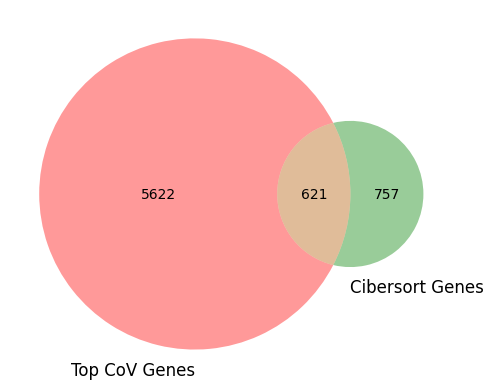

In [10]:
venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [11]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [12]:
np.any(np.isin(union_genes, ["PRDM1"]))

True

### normalize

In [13]:
X_full = X_full.loc[:,union_genes]

# rescale sc_ref and bulks
median_sc_ref = np.median(np.quantile(X_full.iloc[sc_idx], axis=1, q=0.9))
median_bulk = np.median(np.quantile(X_full.iloc[bulk_idx], axis=1, q=0.9))

ratio_medians = median_bulk/median_sc_ref

X_full.iloc[sc_idx] = X_full.iloc[sc_idx]*ratio_medians


In [14]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

In [15]:
idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)
idx_tmp

array([ 8401,  5888, 12523, ...,  4941,  3966,  3499])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 2.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.234508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.911453
[t-SNE] KL divergence after 500 iterations: 1.046239
(5000, 2)
(5000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2600809812.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


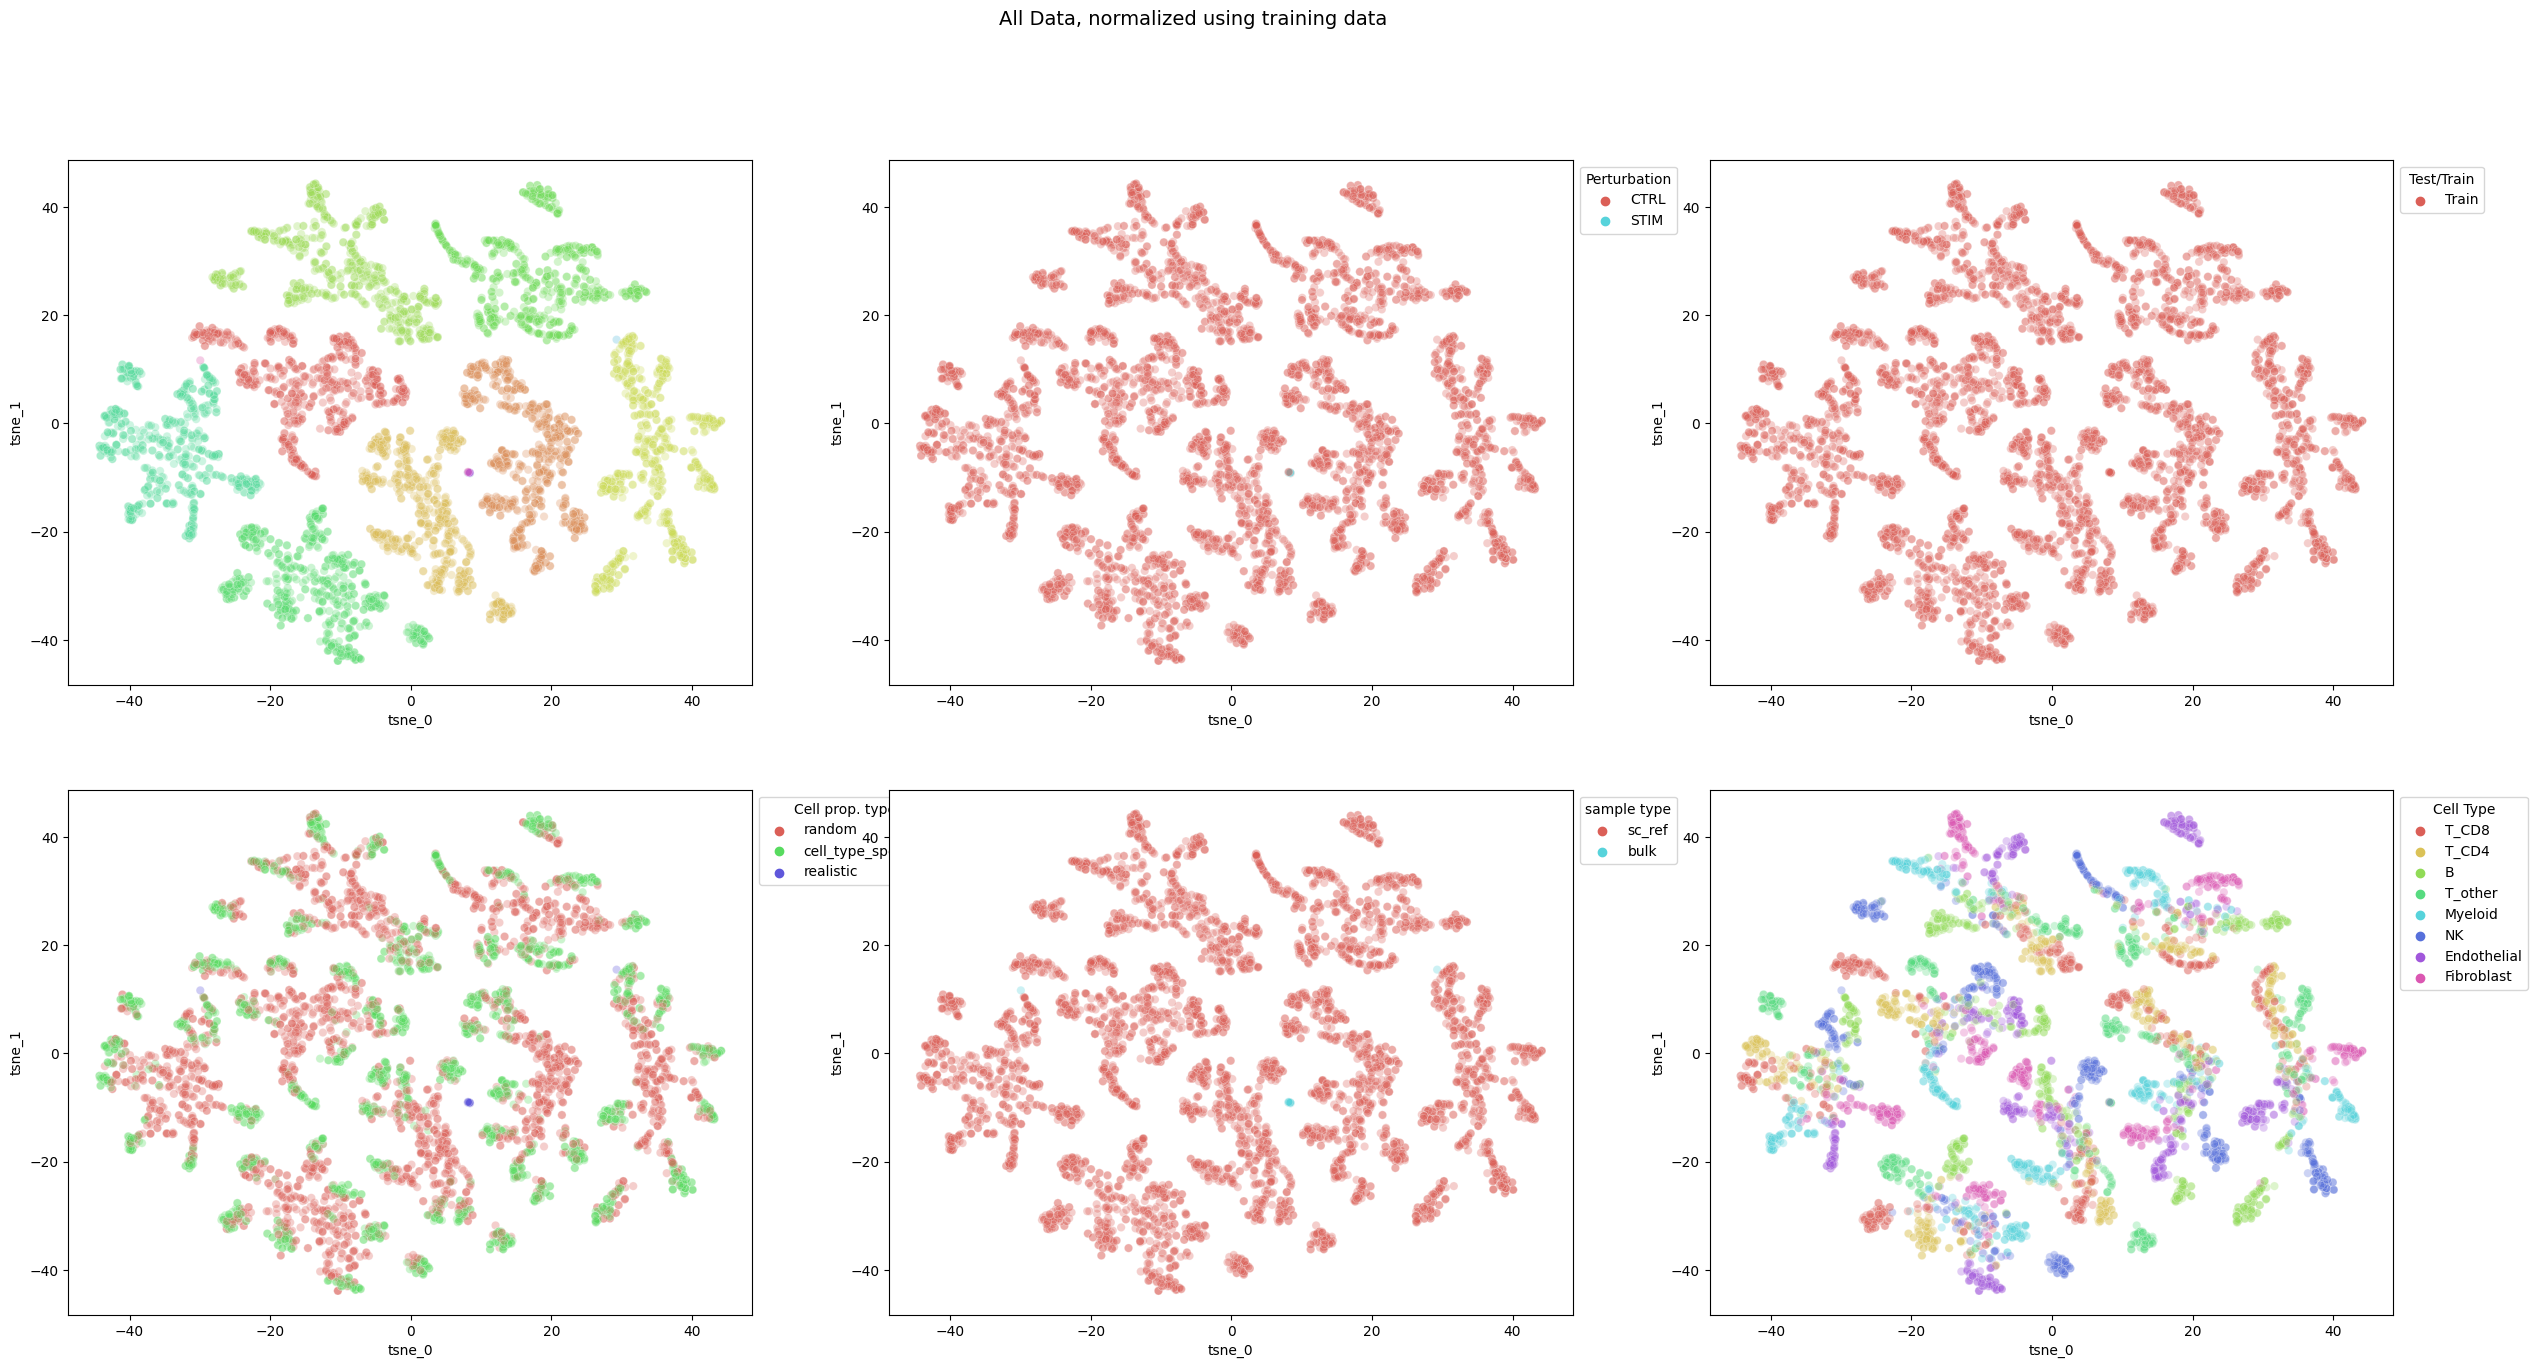

In [16]:
## plot samples

idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)

plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(32, 2)
(32, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


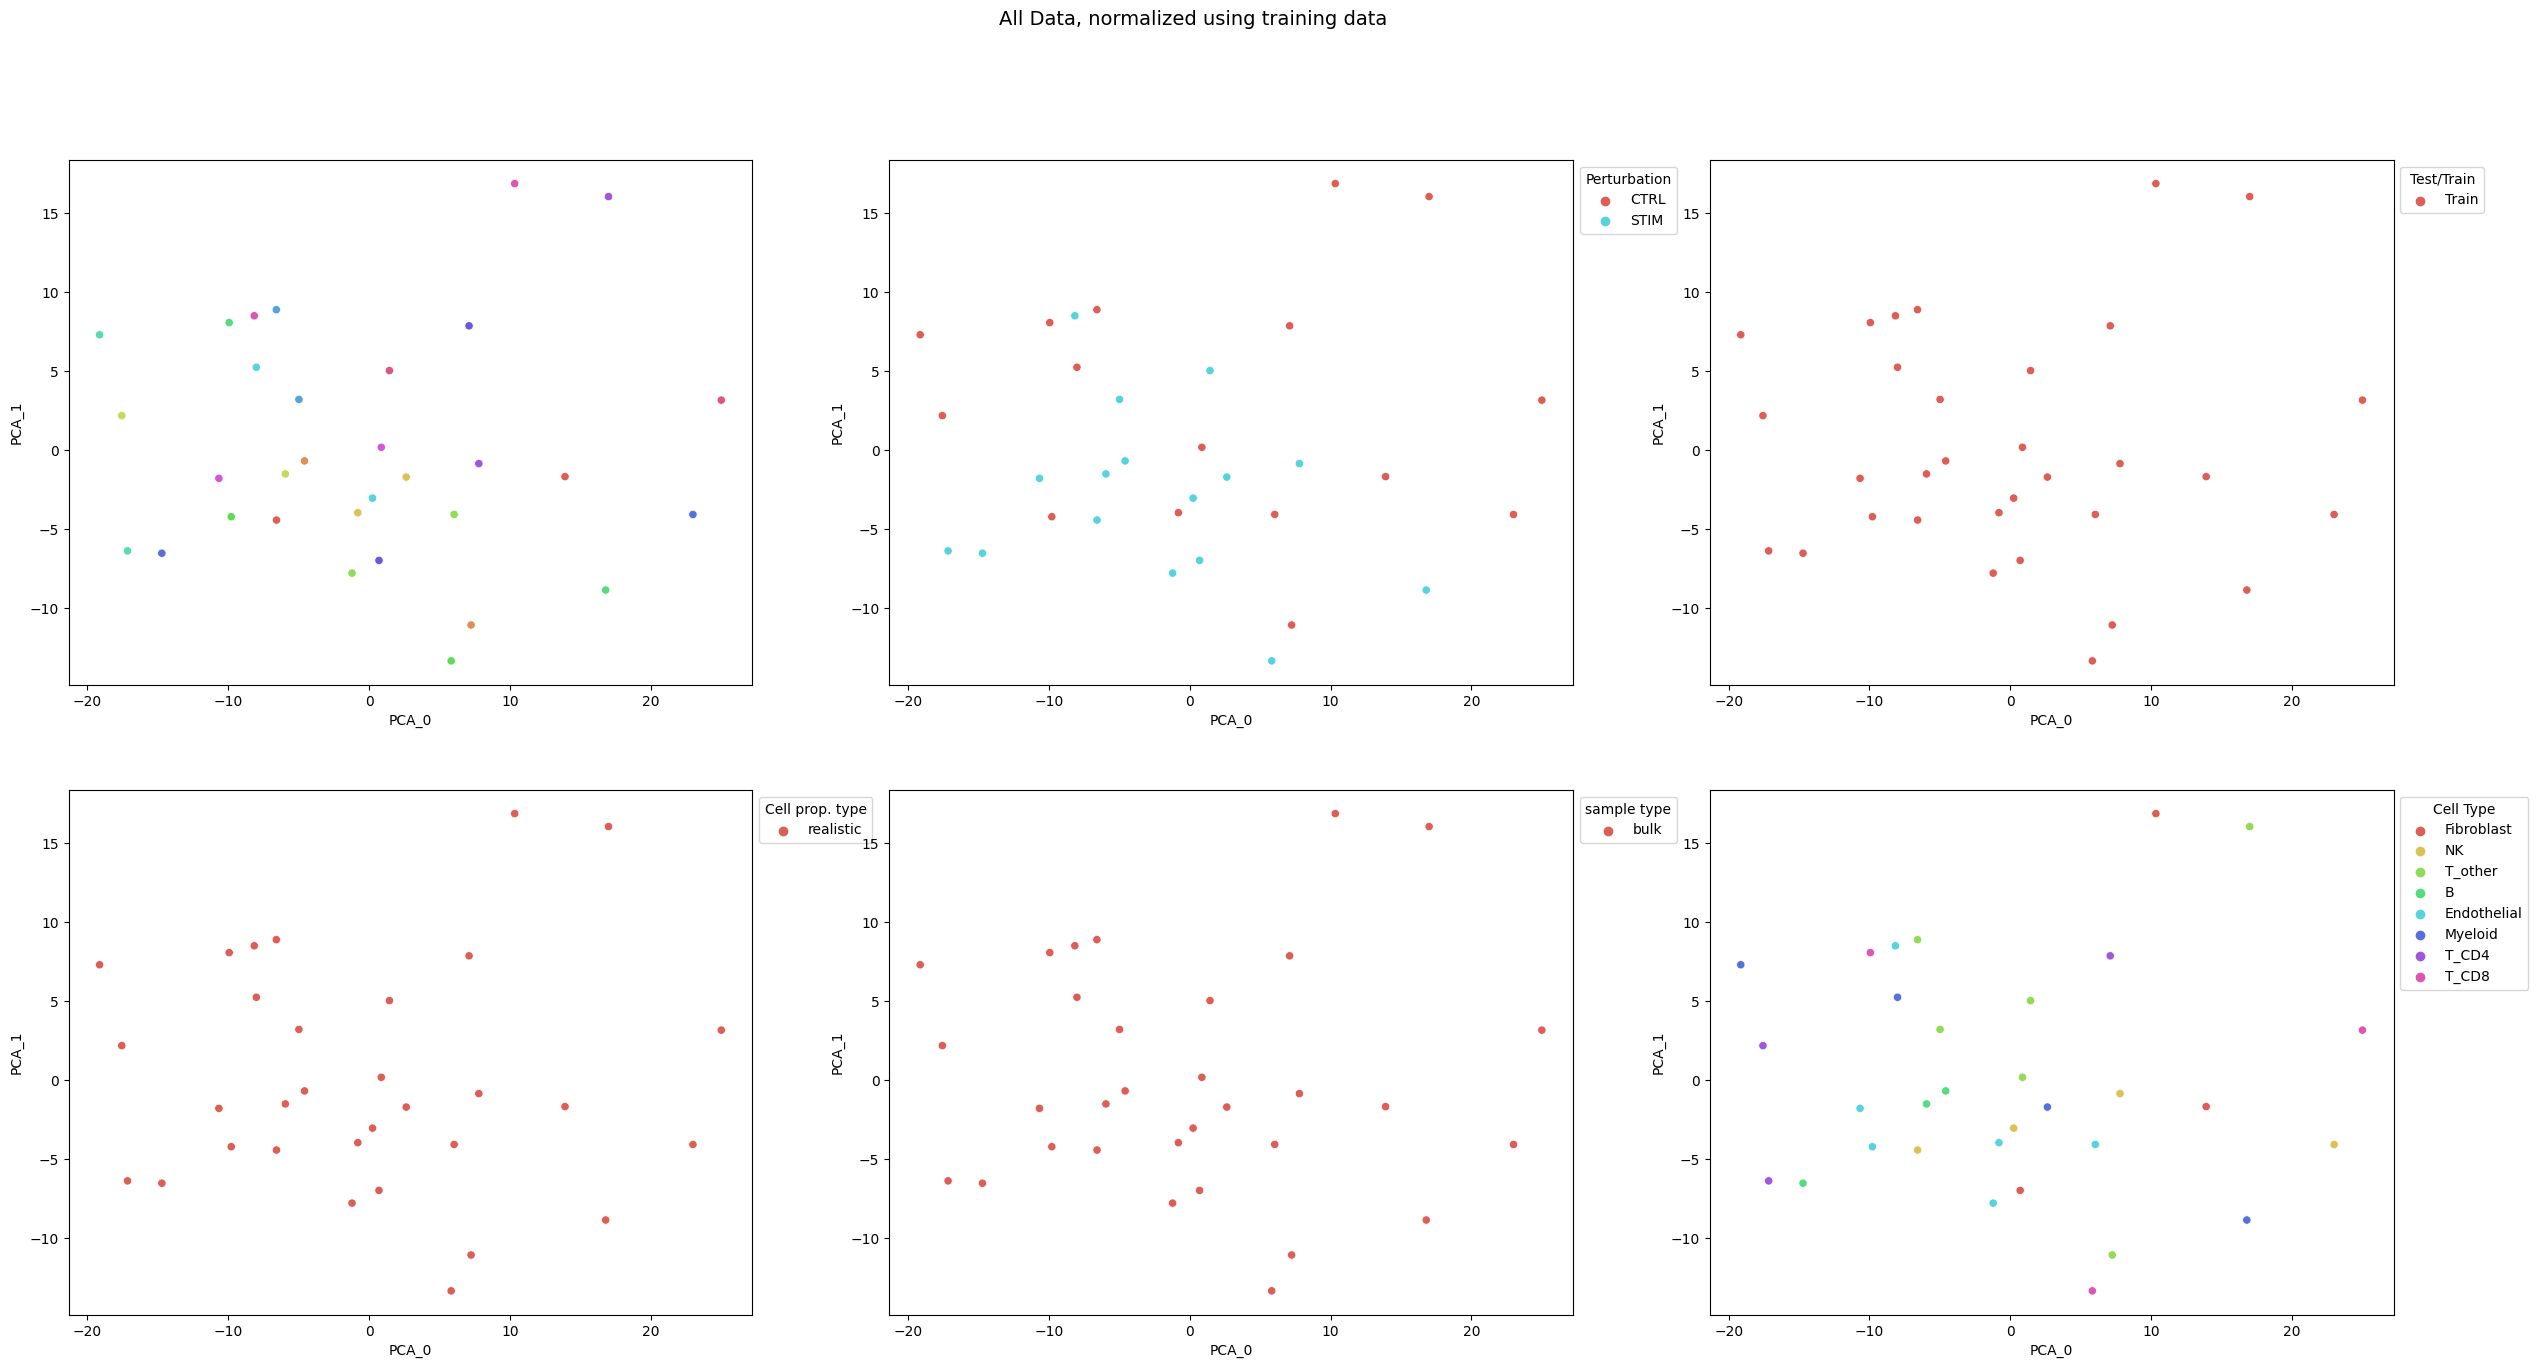

In [17]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 14.062587
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.396149
[t-SNE] KL divergence after 500 iterations: 0.076376
(32, 2)
(32, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


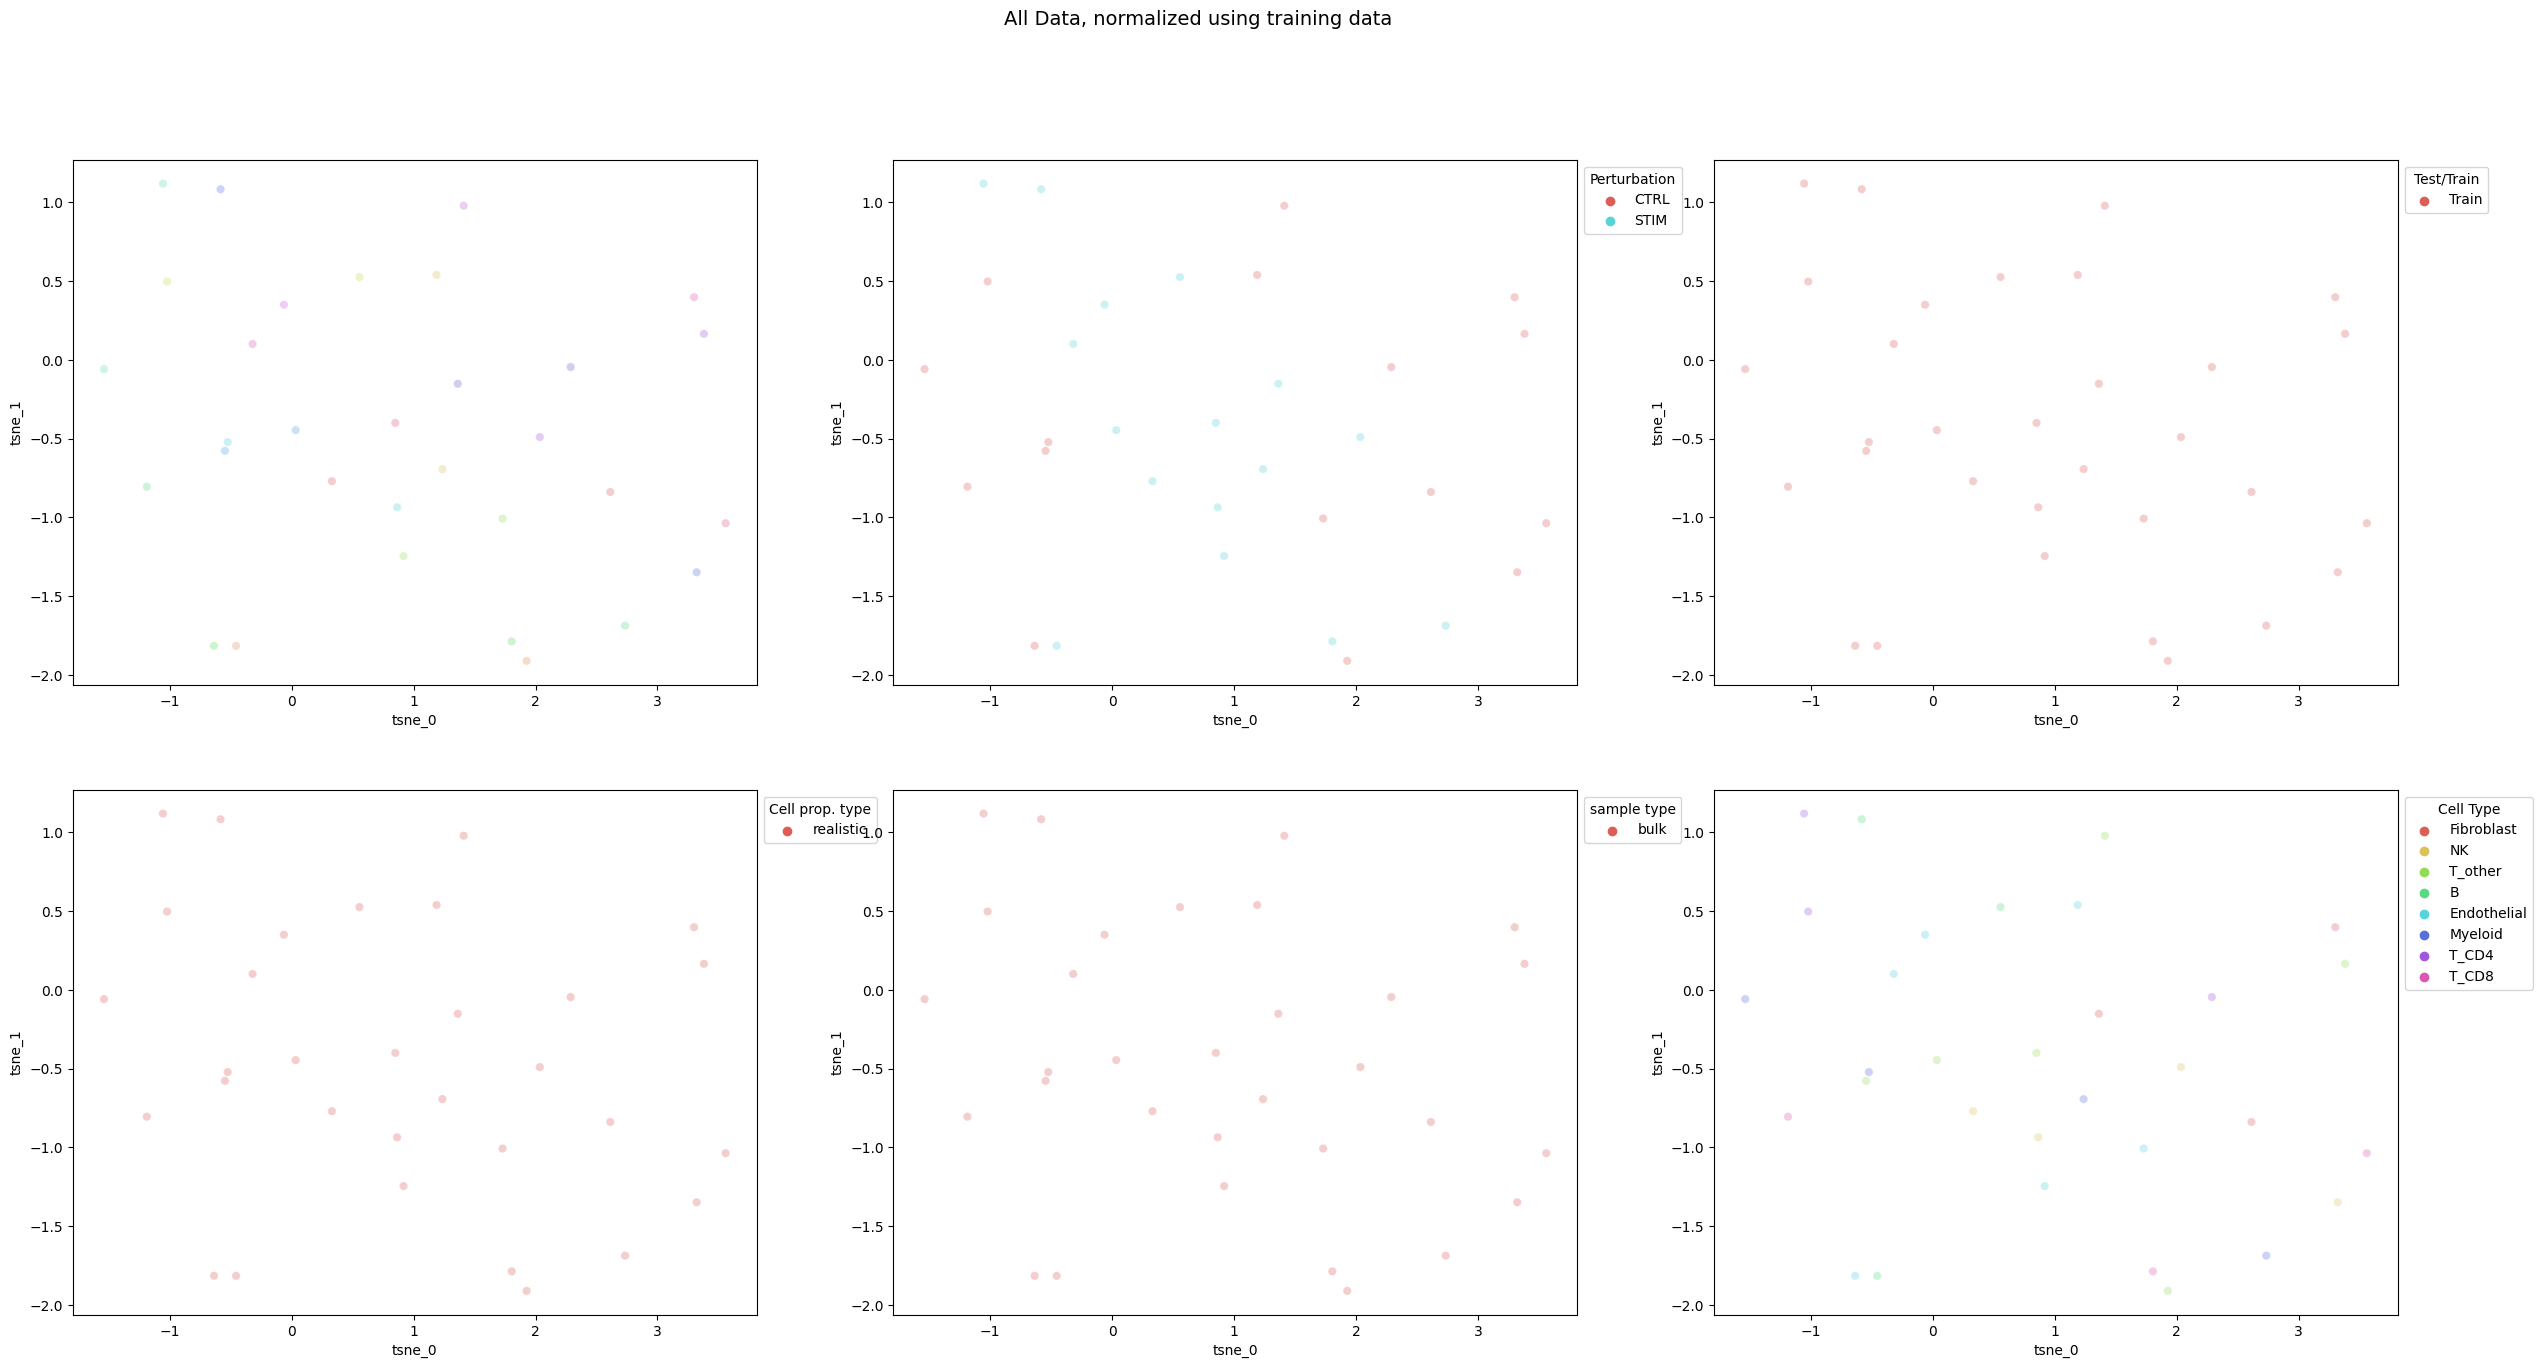

In [18]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [19]:
""" 
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_classifier")

"""
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/allmodel1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/allmodel1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/allmodel1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/allmodel1_{res_id}_classifier")



res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_classifier")



2024-02-14 13:36:43.723424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-02-14 13:36:43.749868: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_5' id:266 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_5}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_10, Identity_5)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:44.505813: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_47' id:685 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_47}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_21, Identity_47)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:44.744104: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_51' id:839 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_51}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_25, Identity_51)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:44.956798: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_53' id:920 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_53}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_26, Identity_53)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:45.649668: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_69' id:1207 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_69}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_32, Identity_69)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:46.543403: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_92' id:1588 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_92}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_44, Identity_92)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:46.908720: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_108' id:1766 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_108}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_54, Identity_108)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:47.223594: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_110' id:1847 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_110}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_55, Identity_110)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:48.051312: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_130' id:2142 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_130}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_63, Identity_130)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:49.109913: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_142' id:2501 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_142}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_71, Identity_142)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:49.586733: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_165' id:2693 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_165}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_82, Identity_165)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-14 13:36:50.013577: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_172' id:2784 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_172}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_86, Identity_172)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Do latent space projectsions

### drug perturbation

In [20]:

res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)



res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res2_enc_unlab, res2_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res3_enc_unlab, res3_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-14 13:36:51.103843: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack/add/z_samp_slack/add' id:375 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack/add/z_samp_slack/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack/BiasAdd, tf_op_layer_z_samp_slack/mul/z_samp_slack/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/davidnat/Documents/projects/greenelab/buddi/buddi/buddi.py:893: SettingWithCopyWarning: 
A

In [21]:
# make anndata for BuDDI
def make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes):

    adata_counts = np.append(res1_decoded_0_0, res1_decoded_0_1, axis=0)
    adata_df = pd.DataFrame(adata_counts)
    adata_df.columns = union_genes

    ad_union_genes = pd.DataFrame(union_genes)
    ad_union_genes.index = union_genes

    res1_meta_df_stim = res1_meta_df.copy()
    res1_meta_df_stim.stim = "STIM"
    res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)

    adata = ad.AnnData(adata_df, obs=res1_meta_df_obs, var=ad_union_genes)

    return (adata, adata_df)


# make anndata for BayesPrism
def make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path):
    
    ## get with bayesprism
    bp_bulk = pd.read_csv(bp_bulk_Z_path, delimiter="\t")
    bp_bulk_meta = pd.read_csv(bp_bulk_Zmeta_path, delimiter="\t")



    def get_stim_id(in_str):
        out_str = "STIM"
        if in_str == "week0":
            out_str = "CTRL"
            
        return(out_str)

    bp_bulk_meta['stim'] = [get_stim_id(str(x)) for x in bp_bulk_meta["time"].tolist()]



    bp_adata_df = pd.DataFrame(bp_bulk)
    bp_union_genes = bp_adata_df.columns
    bp_adata_df = bp_adata_df[bp_union_genes]

    ad_bp_union_genes = pd.DataFrame(bp_union_genes)
    ad_bp_union_genes.index = bp_union_genes


    # format meta data
    bp_bulk_meta["Y_max"] = bp_bulk_meta.cell_type


    # make anndata
    bp_adata = ad.AnnData(bp_adata_df, obs=bp_bulk_meta, var=ad_bp_union_genes)

    return (bp_adata, bp_adata_df)



## Format BuDDI and BayesPrism

In [22]:
adata_res1, adata_res1_df = make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes)
adata_res2, adata_res2_df = make_anndata_buddi(res2_decoded_0_0, res2_decoded_0_1, res2_meta_df, union_genes)
adata_res3, adata_res3_df = make_anndata_buddi(res3_decoded_0_0, res3_decoded_0_1, res3_meta_df, union_genes)
bp_adata, bp_adata_df = make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

## Run GSEA

In [23]:

def run_gsea(cell_type_list, gmt_path, adata, adata_df):


    cell_idx = np.where(np.isin(adata.obs.Y_max, cell_type_list))[0]


    hall_mark = gp.read_gmt(path=gmt_path)
    class_vector = adata[cell_idx, :].obs.stim.to_list() # STIM vs CTRL
    adata_gsea = adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index

    gs = GSEA(data=adata_gsea,
            gene_sets=hall_mark,
            classes = class_vector, # cls=class_vector
            # set permutation_type to phenotype if samples >=15
            permutation_type='phenotype',
            permutation_num=1000, # reduce number to speed up test
            outdir=None,
            method='ratio_of_classes',
            threads=4, seed= 8)
    gs.pheno_pos = "CTRL"
    gs.pheno_neg = "STIM"
    gs.run()

    return gs

def plot_gsea(gmt_path, cell_type_list, in_adata, inadata_df, title):

        gs_res_imm = run_gsea(cell_type_list, gmt_path, in_adata, inadata_df)

        out_fig = gp.dotplot(gs_res_imm.res2d,
                                column="FDR q-val",
                                title=title,
                                cmap=plt.cm.viridis,
                                size=5,
                                figsize=(4,5), cutoff=1)
        return (out_fig, gs_res_imm)



<AxesSubplot: title={'center': 'all_reactome_BuDDI'}, xlabel='NES'>

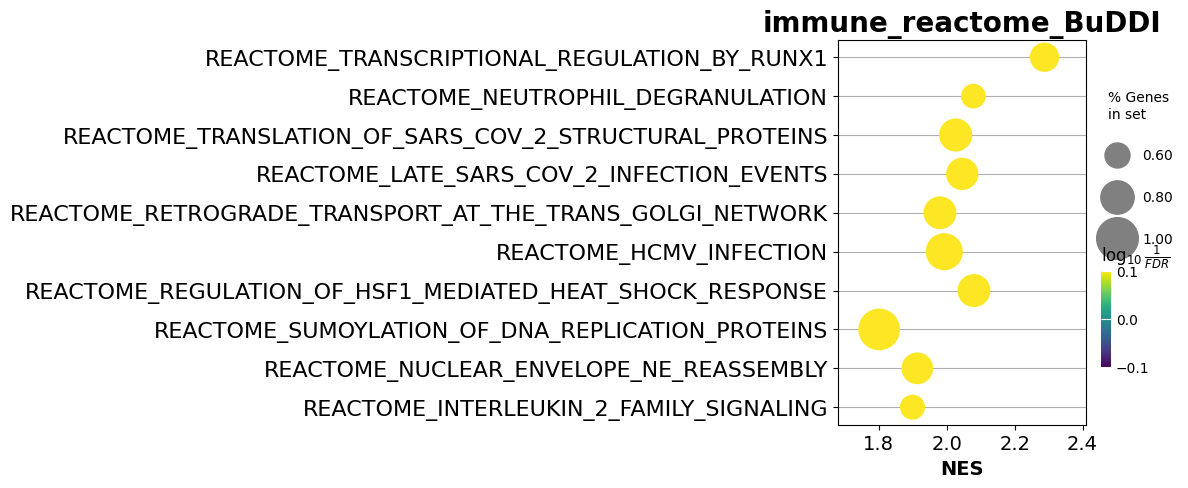

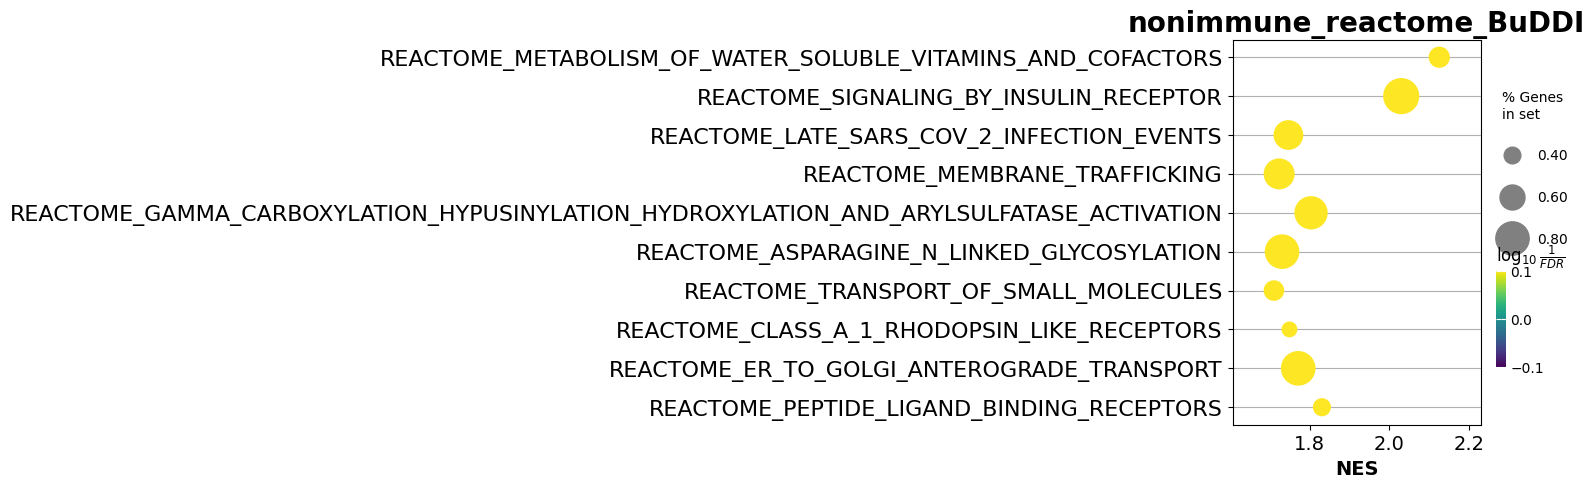

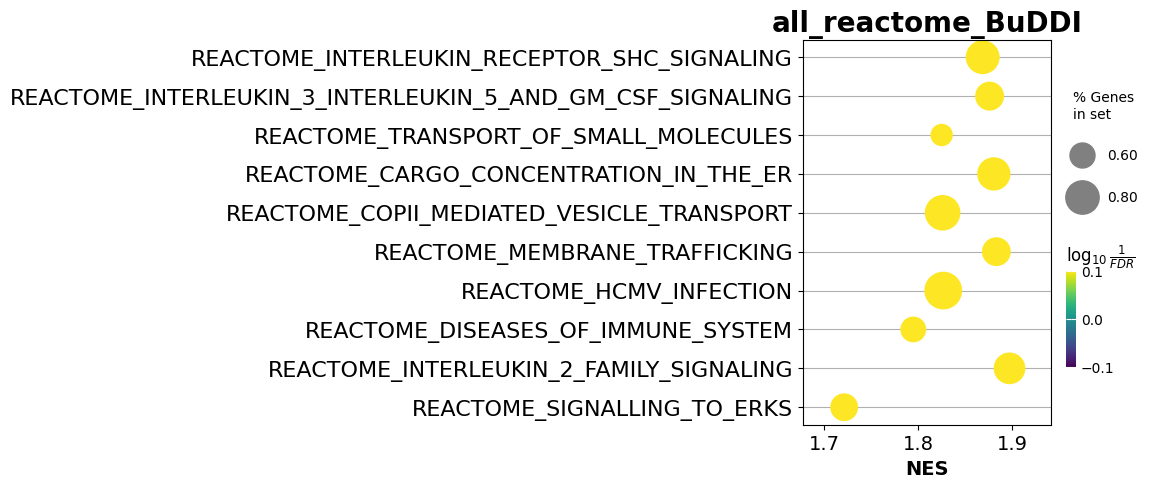

In [24]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

In [25]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

KeyboardInterrupt: 

<AxesSubplot: title={'center': 'all_reactome_BuDDI'}, xlabel='NES'>

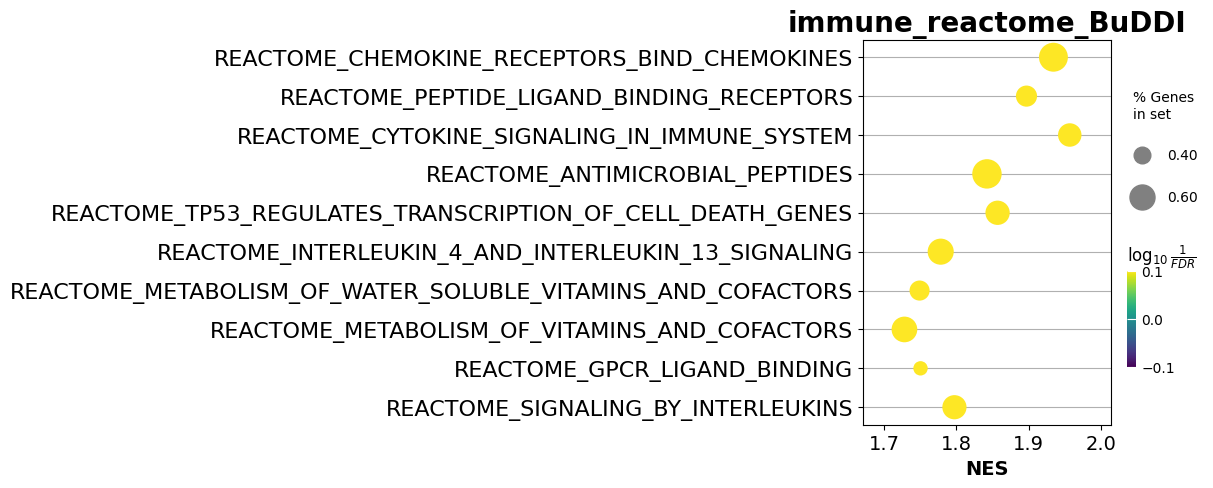

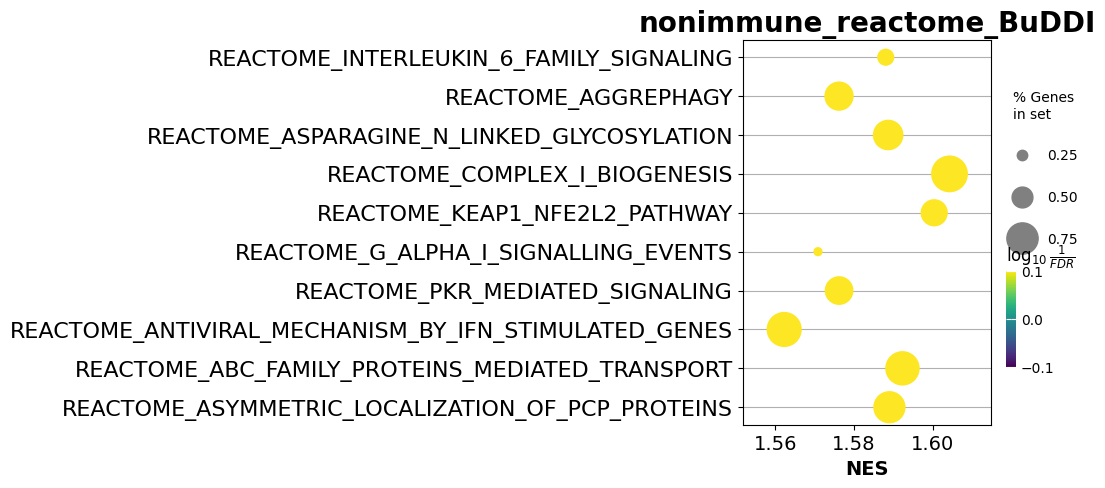

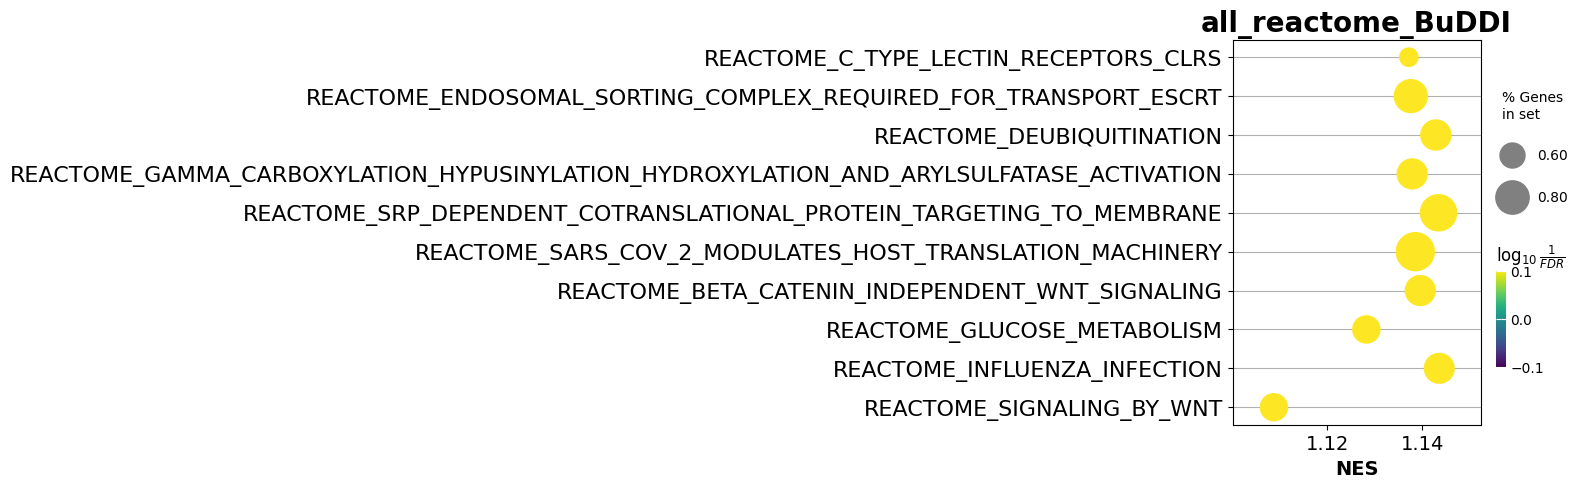

In [ ]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

<AxesSubplot: title={'center': 'all_reactome_BP'}, xlabel='NES'>

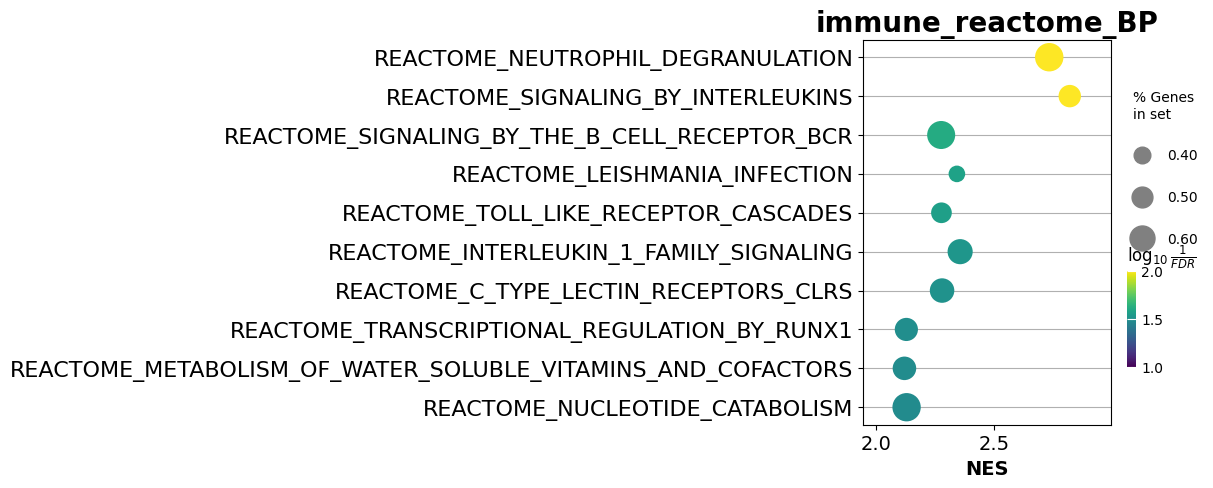

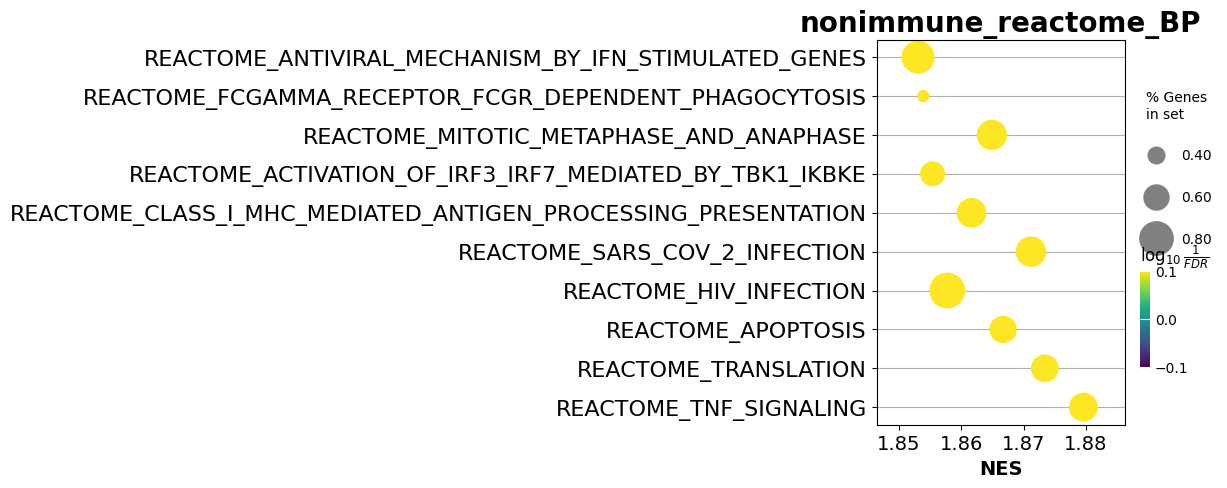

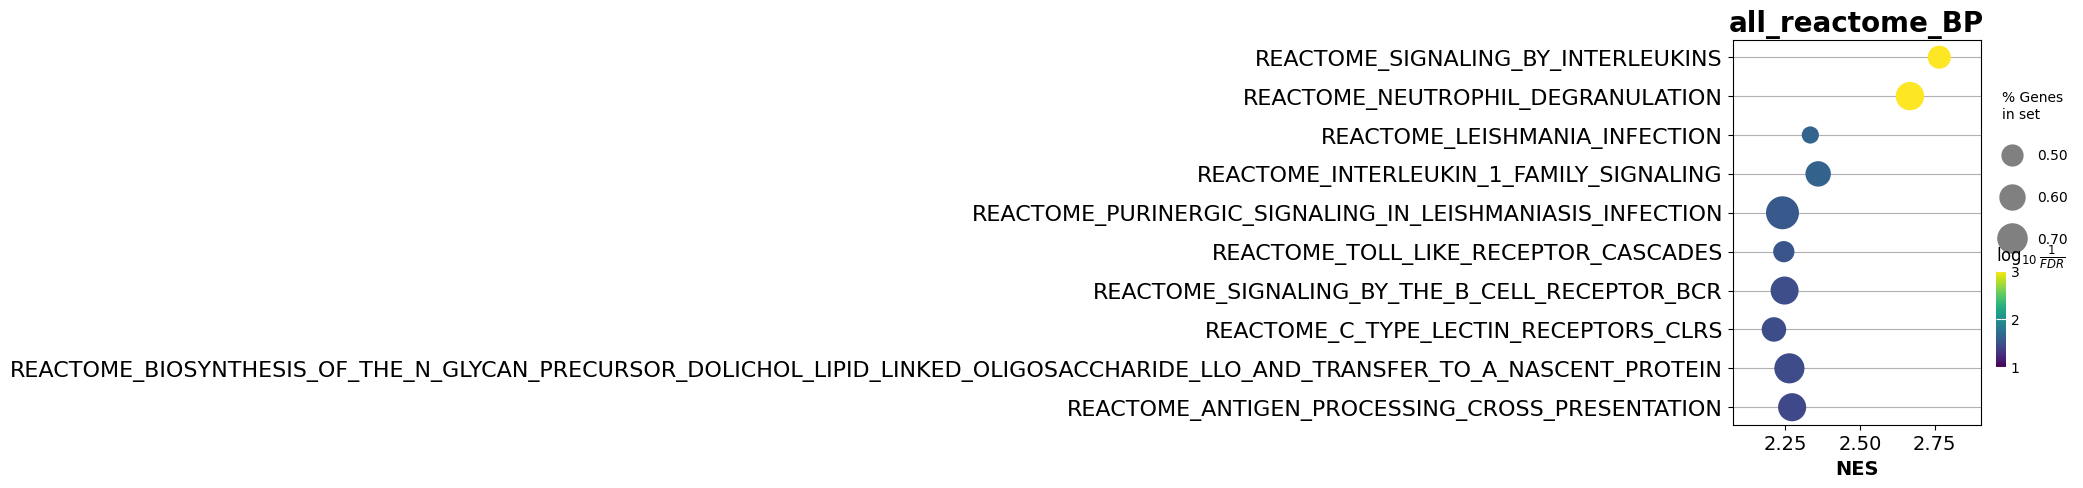

In [ ]:
# BP Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BP"
out_fig, immune_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BP"
out_fig, nonimmune_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BP"
out_fig, all_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

In [ ]:
all_reactome_BP.res2d.iloc[0:10]

Name                                           Term        ES       NES  \
0  gsea   REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM  0.361085  2.711078   
1  gsea             REACTOME_SIGNALING_BY_INTERLEUKINS  0.379093  2.628627   
2  gsea                REACTOME_ADAPTIVE_IMMUNE_SYSTEM  0.321689  2.579732   
3  gsea              REACTOME_NEUTROPHIL_DEGRANULATION   0.42063  2.456686   
4  gsea           REACTOME_TOLL_LIKE_RECEPTOR_CASCADES  0.388655  2.452139   
5  gsea                  REACTOME_LEISHMANIA_INFECTION  0.336642  2.289963   
6  gsea  REACTOME_TOLL_LIKE_RECEPTOR_TLR1_TLR2_CASCADE  0.356044  2.250136   
7  gsea         REACTOME_CELLULAR_RESPONSES_TO_STIMULI  0.278437  2.249841   
8  gsea        REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING  0.405616  2.121575   
9  gsea           REACTOME_G_ALPHA_I_SIGNALLING_EVENTS  0.438549  2.105822   

  NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0       0.0        0.0  258/442  36.88%   
1       0.0       0.0        0.0  167/277  36.88%   
2       0.0       0.0        0.0  211/420  32.74%   
3  0.001376  0.001783      0.004  237/331  39.99%   
4       0.0  0.001427      0.004    58/92  37.40%   
5       0.0  0.009708      0.034   47/121  22.90%   
6       0.0  0.012567      0.052    38/64  37.40%   
7       0.0  0.010996      0.052  202/378  38.12%   
8       0.0  0.044248      0.179    59/86  37.40%   
9       0.0  0.044697       0.19   48/124  18.92%   

                                          Lead_genes  
0  IGHE;FCGR1A;CXCL10;CXCL8;IGHG4;LBP;IL1B;TNFRSF...  
1  IGHE;CXCL10;CXCL8;IGHG4;LBP;IL1B;IL6;MMP1;IL2R...  
2  FCGR1A;CLEC4G;S100A8;S100A9;IGHD;LY96;CD300E;I...  
3  S100A8;S100A9;CLEC4D;SLPI;CR1;RNASE2;CHI3L1;FP...  
4  S100A8;LBP;S100A9;LY96;CTSL;S100B;S100A12;TLR2...  
5  FCGR1A;IGHG4;IL1B;IL6;IGLC3;IGLC2;CD163;IGHG2;...  
6  S100A8;S100A9;LY96;S100B;S100A12;TLR2;TLR1;CD1...  
7  CXCL8;MT1H;IL6;LY96;XBP1;MT1G;COX7C;CYBA;COX6C...  
8  IL1B;S100B;S100A12;PSMB9;PSME2;PTPN2;PSMB3;SEM...  
9  CXCL13;CXCL10;CXCL8;CCL13;CXCL3;AGT;CXCL6;PMCH...

<AxesSubplot: title={'center': 'All Cells'}, xlabel='NES'>

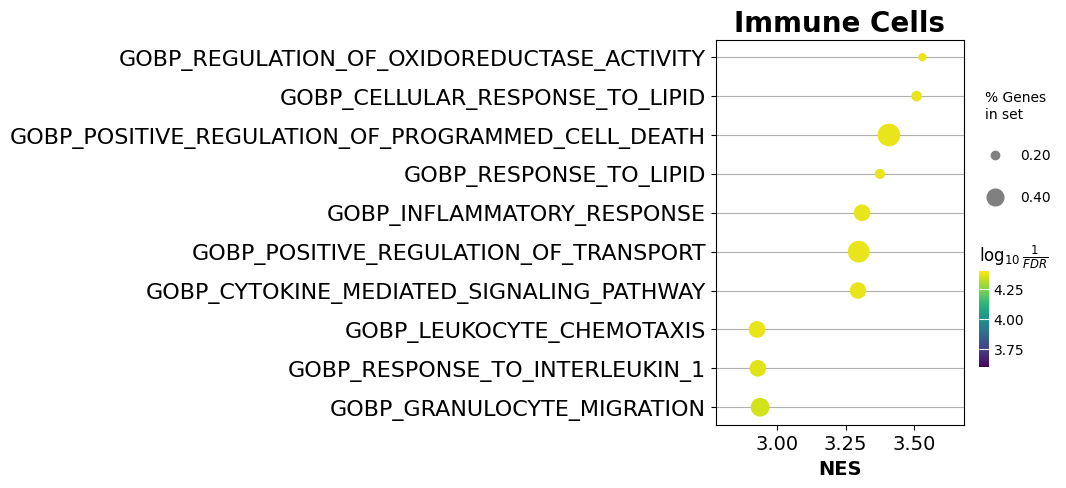

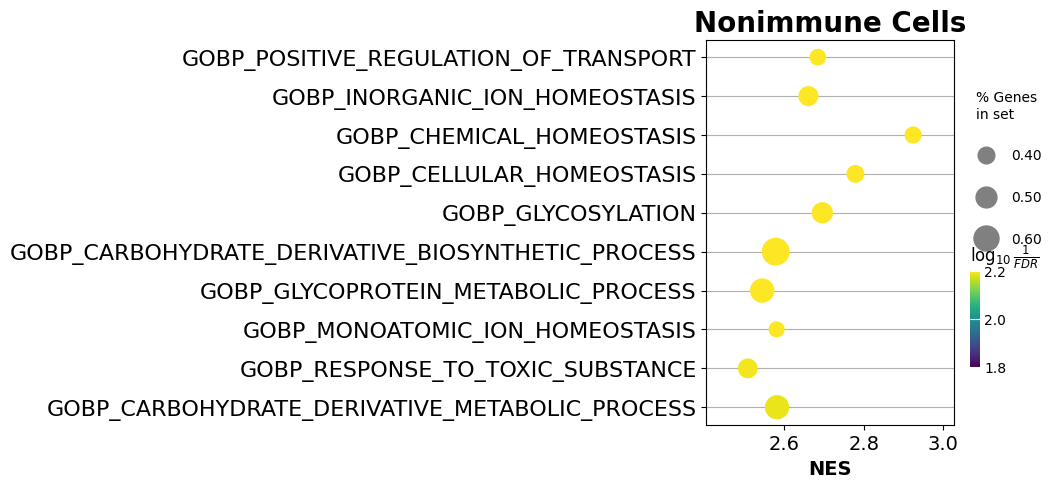

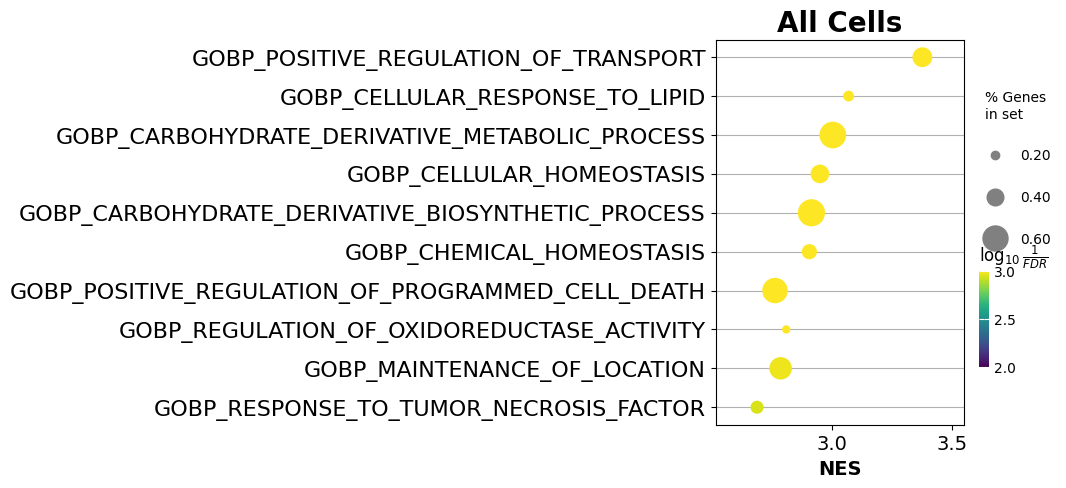

In [40]:
# BuDDI GO

gmt_path = gmt_path_go

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "Immune Cells"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "Nonimmune Cells"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "All Cells"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

In [58]:
terms_paper = ["GOBP_REGULATION_OF_IMMUNOGLOBULIN_PRODUCTION", "GOBP_REGULATION_OF_HUMORAL_IMMUNE_RESPONSE", "GOBP_B_CELL_MEDIATED_IMMUNITY", 
               "GOBP_COMPLEMENT_ACTIVATION", "GOBP_IMMUNOGLOBULIN_PRODUCTION_INVOLVED_IN_IMMUNOGLOBULIN_MEDIATED_IMMUNE_RESPONSE", "GOBP_INTERLEUKIN_6_PRODUCTION",
               "GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION", "GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION_INVOLVED_IN_INFLAMMATORY_RESPONSE",
               "GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY"]

immune_hallmark_BuDDI.res2d.iloc[np.where(np.isin(immune_hallmark_BuDDI.res2d.Term, terms_paper))[0]]

Name                                               Term        ES  \
6     gsea           GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY  0.365199   
221   gsea                      GOBP_INTERLEUKIN_6_PRODUCTION  0.348755   
283   gsea         GOBP_REGULATION_OF_HUMORAL_IMMUNE_RESPONSE  0.507719   
333   gsea    GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION  0.207717   
517   gsea       GOBP_REGULATION_OF_IMMUNOGLOBULIN_PRODUCTION  0.301089   
549   gsea                      GOBP_B_CELL_MEDIATED_IMMUNITY  0.450922   
642   gsea                         GOBP_COMPLEMENT_ACTIVATION  0.457382   
827   gsea  GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTIO...  0.334981   
1259  gsea  GOBP_IMMUNOGLOBULIN_PRODUCTION_INVOLVED_IN_IMM...  0.243664   

           NES NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
6     3.295097       0.0       0.0        0.0  112/282  20.91%   
221   2.218172  0.002041  0.008368      0.395   59/102  33.11%   
283   2.126044  0.001972  0.013478       0.57    18/26  29.90%   
333   2.066141  0.018182  0.017955      0.689   89/179  39.70%   
517   1.862162  0.008147  0.047681      0.973    21/45  28.79%   
549   1.831422   0.01938  0.054212      0.987   65/122  20.60%   
642   1.750462  0.041667  0.074684      0.999    31/39  40.86%   
827   1.590222  0.031434  0.135431        1.0     6/17  14.73%   
1259  1.300334  0.182004   0.32064        1.0     6/27   7.96%   

                                             Lead_genes  
6     CXCL5;CCL7;MMP12;CXCL8;CXCL3;CXCL13;IL1B;CCL8;...  
221   LBP;IL1B;IL6;TLR2;TLR8;TLR1;PYCARD;AIF1;LILRB2...  
283   CXCL13;IL1B;CR1;FCGR2B;CR2;CCR7;SVEP1;SPNS2;LT...  
333   LBP;CR1;IL6;IDO1;CARD16;APOD;ABCD2;FCGR2B;TLR8...  
517   CR1;IL6;CD28;FCGR2B;TNFRSF4;TFRC;CD86;MZB1;CD4...  
549   FCGR1A;CR1;IGHV6-1;IGHV3-20;IGHD;IGHV3-66;IGHV...  
642   IL1B;CR1;FCN1;C4B;C7;IGHE;C6;CFP;C2;CFI;KRT1;C...  
827                APOD;ABCD2;PYCARD;LILRB4;CHID1;TREM2  
1259                      CD28;BATF;TFRC;CD40;IL10;GAPT

In [47]:
adata_res1

AnnData object with n_obs × n_vars = 16000 × 7000
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'response', 'subject_id', 'pipeline_date', 'site', 'treatment', 'biopsied', 'sex', 'age', 'CDAI', 'disease_duration', 'tissue_type', 'krenn_lining', 'krenn_inflammation', 'single_cell_tech', 'cell_count_to_10x', 'mRNA_run', 'protein_run', 'atac_run', 'qc', 'Y_max'
    var: 0

<AxesSubplot: title={'center': 'All Cells'}, xlabel='NES'>

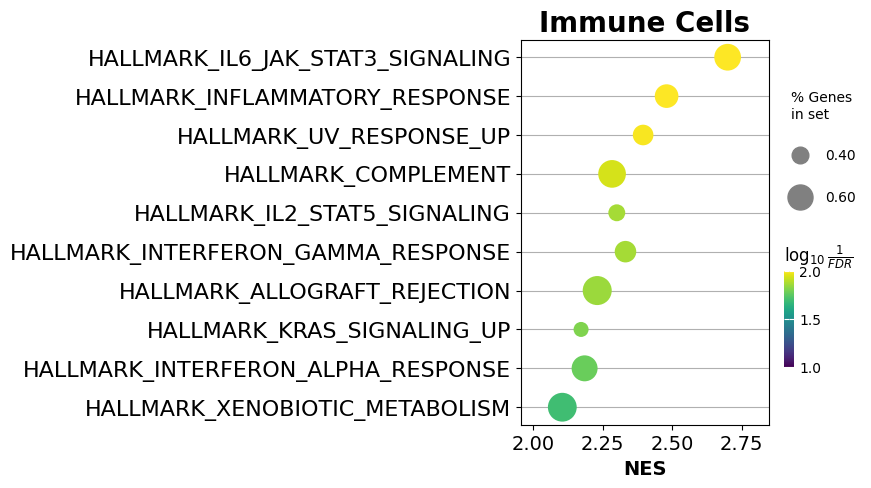

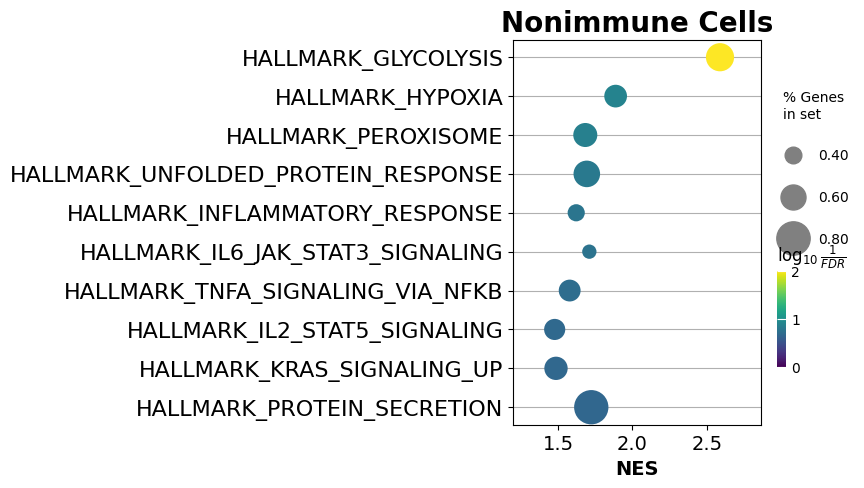

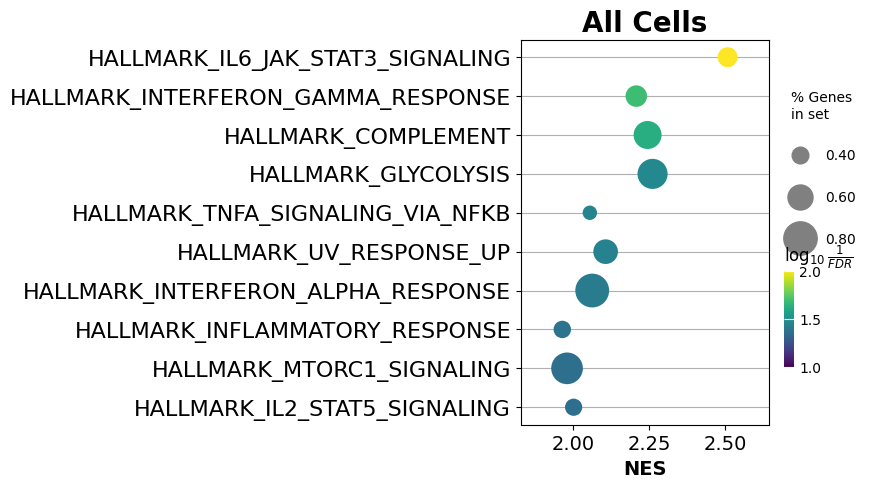

In [24]:
# BuDDI Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "Immune Cells"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "Nonimmune Cells"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "All Cells"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

In [25]:
immune_hallmark_BuDDI.res2d

Name                                        Term        ES       NES  \
0   gsea            HALLMARK_IL6_JAK_STAT3_SIGNALING  0.504424   2.69933   
1   gsea              HALLMARK_INFLAMMATORY_RESPONSE  0.457623  2.480149   
2   gsea                     HALLMARK_UV_RESPONSE_UP  0.283376  2.395817   
3   gsea          HALLMARK_INTERFERON_GAMMA_RESPONSE  0.442474  2.332517   
4   gsea                HALLMARK_IL2_STAT5_SIGNALING   0.26788  2.301293   
5   gsea                         HALLMARK_COMPLEMENT  0.353188  2.284362   
6   gsea                HALLMARK_ALLOGRAFT_REJECTION  0.472704  2.231009   
7   gsea          HALLMARK_INTERFERON_ALPHA_RESPONSE  0.485252  2.185746   
8   gsea                  HALLMARK_KRAS_SIGNALING_UP  0.314113  2.173043   
9   gsea              HALLMARK_XENOBIOTIC_METABOLISM  0.345904  2.105665   
10  gsea             HALLMARK_ESTROGEN_RESPONSE_LATE  0.264696  2.063707   
11  gsea            HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.306602  1.993431   
12  gsea                         HALLMARK_GLYCOLYSIS  0.268757  1.993088   
13  gsea                   HALLMARK_MTORC1_SIGNALING  0.326528  1.981726   
14  gsea            HALLMARK_PI3K_AKT_MTOR_SIGNALING  0.257983   1.83396   
15  gsea               HALLMARK_BILE_ACID_METABOLISM  0.290699  1.782737   
16  gsea                        HALLMARK_P53_PATHWAY  0.175223  1.754541   
17  gsea         HALLMARK_WNT_BETA_CATENIN_SIGNALING -0.411756 -1.752954   
18  gsea          HALLMARK_UNFOLDED_PROTEIN_RESPONSE  0.281206  1.717975   
19  gsea                       HALLMARK_ADIPOGENESIS  0.297422  1.717126   
20  gsea                     HALLMARK_MYC_TARGETS_V1    0.3888  1.680529   
21  gsea                            HALLMARK_HYPOXIA  0.218536   1.67646   
22  gsea    HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  0.350437   1.65101   
23  gsea              HALLMARK_FATTY_ACID_METABOLISM  0.321242  1.611689   
24  gsea          HALLMARK_OXIDATIVE_PHOSPHORYLATION  0.436135  1.571364   
25  gsea                         HALLMARK_PEROXISOME  0.231413  1.497301   
26  gsea            HALLMARK_CHOLESTEROL_HOMEOSTASIS  0.240521  1.493791   
27  gsea                     HALLMARK_MYC_TARGETS_V2  0.282889    1.3438   
28  gsea                    HALLMARK_HEME_METABOLISM  0.134788  1.334544   
29  gsea                     HALLMARK_G2M_CHECKPOINT   0.16513  1.319436   
30  gsea                     HALLMARK_APICAL_SURFACE  0.225265  1.261452   
31  gsea                        HALLMARK_E2F_TARGETS  0.165457  1.258023   
32  gsea                          HALLMARK_APOPTOSIS  0.170094  1.242512   
33  gsea                  HALLMARK_PROTEIN_SECRETION  0.228518  1.206059   
34  gsea                    HALLMARK_MITOTIC_SPINDLE -0.210047 -1.199037   
35  gsea                    HALLMARK_NOTCH_SIGNALING -0.252824 -1.195368   
36  gsea                         HALLMARK_DNA_REPAIR   0.16611  1.051109   
37  gsea                       HALLMARK_ANGIOGENESIS  0.202709  1.033891   
38  gsea                  HALLMARK_KRAS_SIGNALING_DN  0.205485  1.010246   
39  gsea                  HALLMARK_ANDROGEN_RESPONSE  0.130826  0.991896   
40  gsea                    HALLMARK_SPERMATOGENESIS  0.142789  0.908005   
41  gsea                        HALLMARK_COAGULATION  0.183733  0.904074   
42  gsea                     HALLMARK_UV_RESPONSE_DN -0.107089 -0.781725   
43  gsea                    HALLMARK_APICAL_JUNCTION -0.090352 -0.698619   
44  gsea                 HALLMARK_HEDGEHOG_SIGNALING  0.169474  0.690104   
45  gsea                 HALLMARK_TGF_BETA_SIGNALING  -0.09714 -0.629834   
46  gsea  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.123748  0.616306   
47  gsea                         HALLMARK_MYOGENESIS -0.107643 -0.612007   
48  gsea            HALLMARK_ESTROGEN_RESPONSE_EARLY  0.070097   0.60803   

   NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0       0.0        0.0    43/67  27.73%   
1        0.0  0.009348       0.01   84/148  25.20%   
2        0.0  0.010197      0.016    46/9

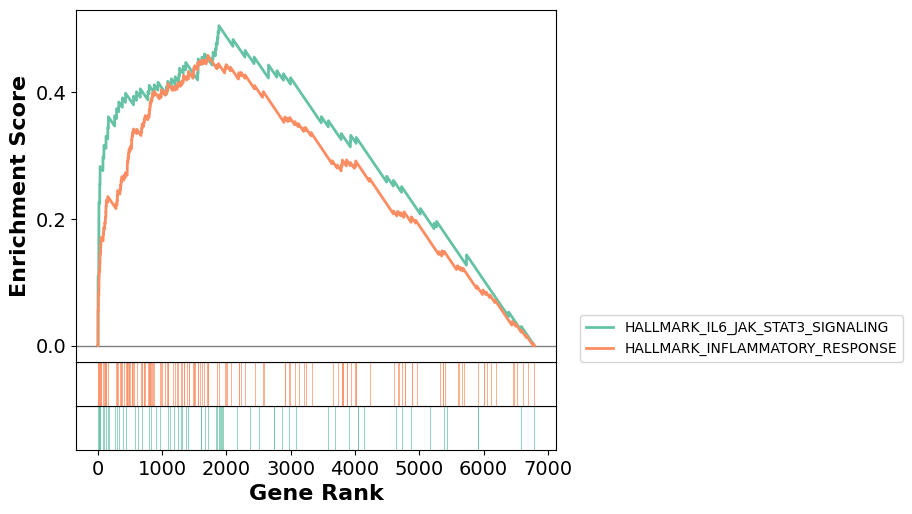

In [29]:

terms = immune_hallmark_BuDDI.res2d.Term
axs = immune_hallmark_BuDDI.plot(terms[[0,1]], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )


In [30]:
nonimmune_hallmark_BuDDI.res2d

Name                                        Term        ES       NES  \
0   gsea                         HALLMARK_GLYCOLYSIS  0.337218   2.58976   
1   gsea                            HALLMARK_HYPOXIA  0.206872  1.886393   
2   gsea                  HALLMARK_PROTEIN_SECRETION  0.339231  1.722208   
3   gsea            HALLMARK_IL6_JAK_STAT3_SIGNALING  0.393626  1.709118   
4   gsea          HALLMARK_UNFOLDED_PROTEIN_RESPONSE  0.342358  1.692054   
5   gsea                         HALLMARK_PEROXISOME  0.256577   1.68185   
6   gsea                 HALLMARK_TGF_BETA_SIGNALING -0.237558 -1.641333   
7   gsea              HALLMARK_INFLAMMATORY_RESPONSE   0.36639  1.620723   
8   gsea            HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.28944   1.57661   
9   gsea         HALLMARK_WNT_BETA_CATENIN_SIGNALING -0.386953 -1.512941   
10  gsea                        HALLMARK_COAGULATION  0.274454   1.50958   
11  gsea                       HALLMARK_ANGIOGENESIS  0.253534  1.503218   
12  gsea                  HALLMARK_ANDROGEN_RESPONSE  0.173965  1.487951   
13  gsea                        HALLMARK_P53_PATHWAY  0.182593  1.484978   
14  gsea                  HALLMARK_KRAS_SIGNALING_UP  0.237644  1.484523   
15  gsea                HALLMARK_IL2_STAT5_SIGNALING  0.209305  1.475603   
16  gsea                         HALLMARK_COMPLEMENT  0.303274  1.443922   
17  gsea                       HALLMARK_ADIPOGENESIS  0.191742  1.417858   
18  gsea          HALLMARK_INTERFERON_GAMMA_RESPONSE  0.384018  1.403228   
19  gsea             HALLMARK_ESTROGEN_RESPONSE_LATE  0.174987  1.400335   
20  gsea              HALLMARK_XENOBIOTIC_METABOLISM  0.198964  1.400155   
21  gsea                   HALLMARK_MTORC1_SIGNALING  0.302392  1.390444   
22  gsea                    HALLMARK_HEME_METABOLISM  0.142514   1.38477   
23  gsea          HALLMARK_INTERFERON_ALPHA_RESPONSE  0.386674  1.370256   
24  gsea            HALLMARK_CHOLESTEROL_HOMEOSTASIS  0.205294  1.360454   
25  gsea  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.202707  1.347019   
26  gsea              HALLMARK_FATTY_ACID_METABOLISM  0.230716  1.281431   
27  gsea                     HALLMARK_MYC_TARGETS_V1  0.392539  1.262315   
28  gsea                HALLMARK_ALLOGRAFT_REJECTION  0.403012  1.245581   
29  gsea                     HALLMARK_UV_RESPONSE_UP   0.18994    1.2309   
30  gsea                    HALLMARK_MITOTIC_SPINDLE -0.225073 -1.219868   
31  gsea    HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  0.316003  1.218967   
32  gsea          HALLMARK_OXIDATIVE_PHOSPHORYLATION  0.387308  1.213378   
33  gsea                  HALLMARK_KRAS_SIGNALING_DN  0.226797  1.112413   
34  gsea                        HALLMARK_E2F_TARGETS  0.178399  1.078963   
35  gsea                          HALLMARK_APOPTOSIS  0.193344  1.078018   
36  gsea                         HALLMARK_DNA_REPAIR  0.181522  1.072592   
37  gsea                    HALLMARK_NOTCH_SIGNALING -0.257818 -1.057317   
38  gsea            HALLMARK_PI3K_AKT_MTOR_SIGNALING  0.189664  1.052582   
39  gsea                     HALLMARK_G2M_CHECKPOINT  0.133876  1.035934   
40  gsea                         HALLMARK_MYOGENESIS -0.171158 -0.951318   
41  gsea                 HALLMARK_HEDGEHOG_SIGNALING -0.220883 -0.830738   
42  gsea                    HALLMARK_SPERMATOGENESIS -0.121628 -0.815133   
43  gsea                     HALLMARK_APICAL_SURFACE -0.134636 -0.704474   
44  gsea                    HALLMARK_APICAL_JUNCTION  -0.08054 -0.627865   
45  gsea               HALLMARK_BILE_ACID_METABOLISM  0.080317  0.588829   
46  gsea            HALLMARK_ESTROGEN_RESPONSE_EARLY -0.084632 -0.587239   
47  gsea                     HALLMARK_UV_RESPONSE_DN -0.103574 -0.568849   
48  gsea                     HALLMARK_MYC_TARGETS_V2  0.127719  0.552905   

   NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0  0.002986      0.002   73/108  41.87%   
1   0.024119  0.126916      0.115   78/143  43.10%   
2   0.007707  0.219489      0.269    56/6

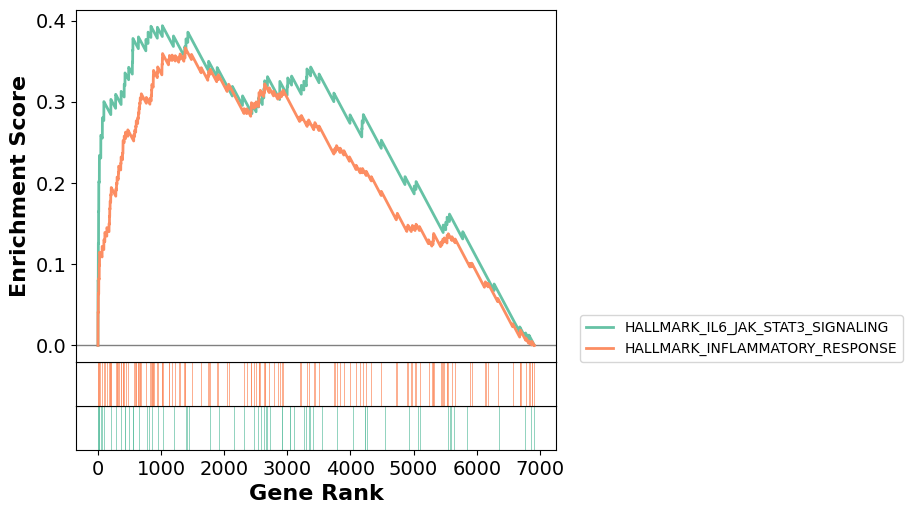

In [32]:

terms = nonimmune_hallmark_BuDDI.res2d.Term
axs = nonimmune_hallmark_BuDDI.plot(terms[[3,7]], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )


In [24]:
# BuDDI Hallmark

gmt_path = gmt_path_go

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BuDDI"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BuDDI"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BuDDI"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

<AxesSubplot: title={'center': 'all_hallmark_BuDDI'}, xlabel='NES'>

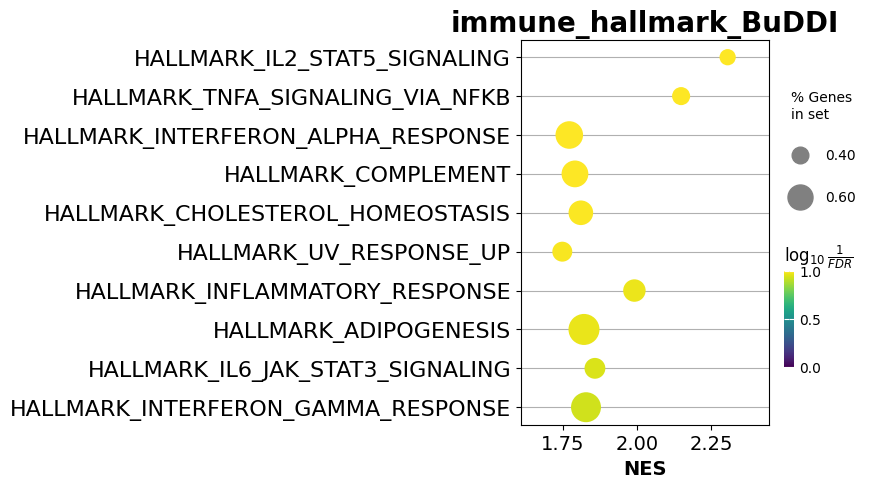

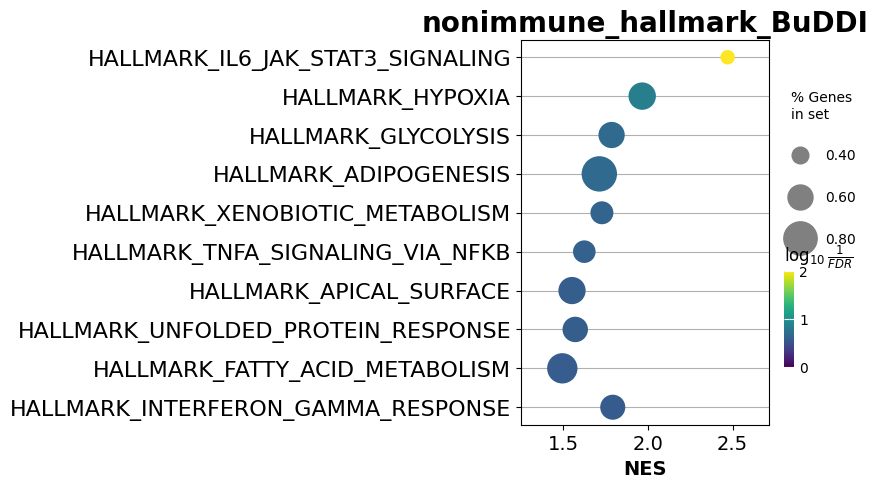

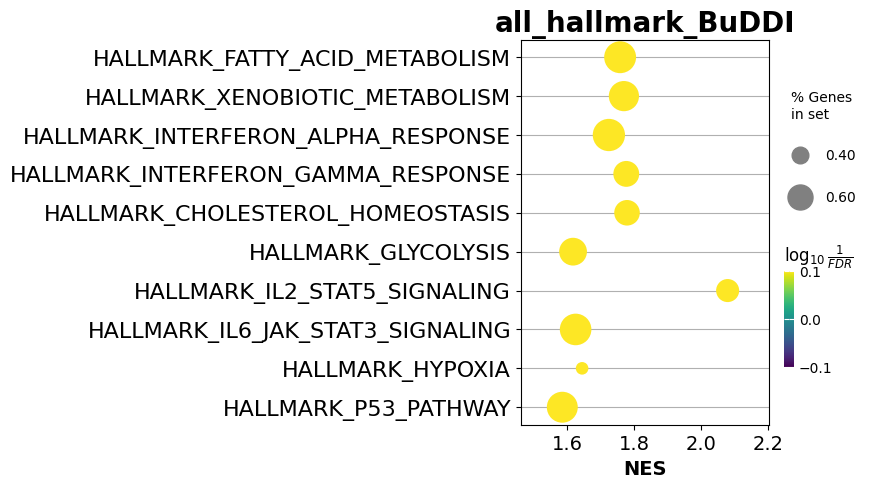

In [ ]:
# BuDDI Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BuDDI"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BuDDI"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BuDDI"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

<AxesSubplot: title={'center': 'all_hallmark_BP'}, xlabel='NES'>

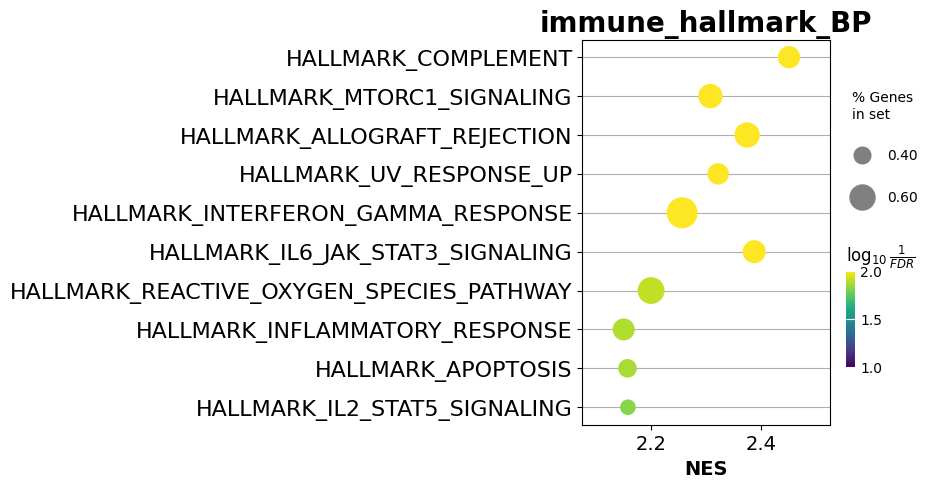

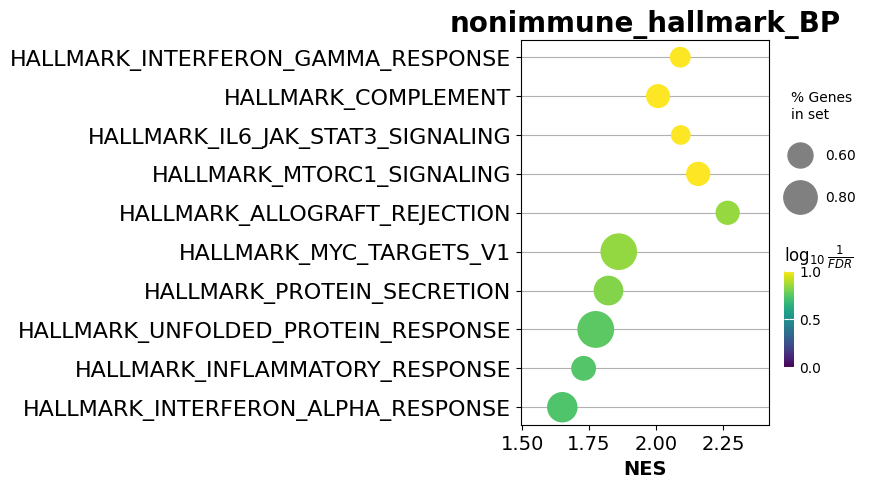

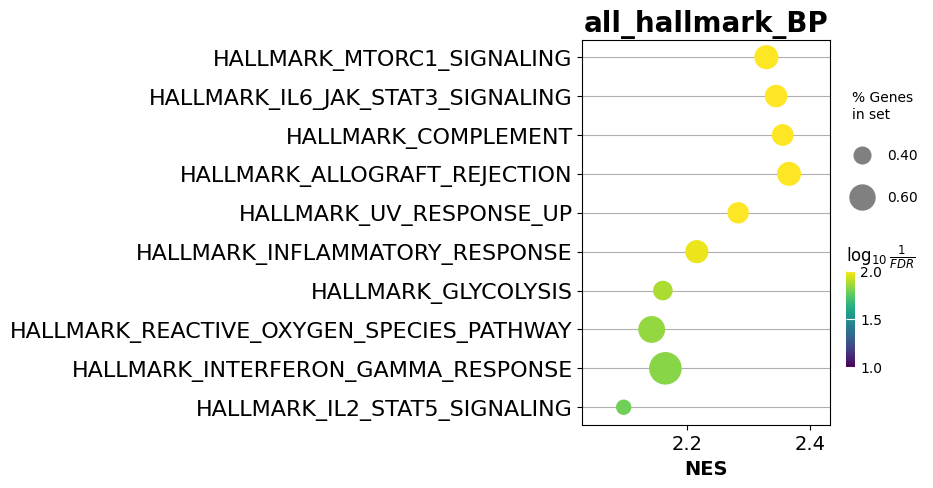

In [ ]:
# BP Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BP"
out_fig, immune_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BP"
out_fig, nonimmune_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BP"
out_fig, all_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

In [ ]:
all_hallmark_BP.res2d.iloc[0:10]

Name                                      Term        ES       NES  \
0  gsea              HALLMARK_ALLOGRAFT_REJECTION  0.602191  2.365865   
1  gsea                       HALLMARK_COMPLEMENT  0.454166  2.355699   
2  gsea          HALLMARK_IL6_JAK_STAT3_SIGNALING  0.592571  2.344888   
3  gsea                 HALLMARK_MTORC1_SIGNALING   0.38711  2.329126   
4  gsea                   HALLMARK_UV_RESPONSE_UP  0.312231  2.283253   
5  gsea            HALLMARK_INFLAMMATORY_RESPONSE  0.523459  2.216031   
6  gsea        HALLMARK_INTERFERON_GAMMA_RESPONSE  0.573289  2.165025   
7  gsea                       HALLMARK_GLYCOLYSIS  0.329188  2.160933   
8  gsea  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  0.433747  2.142748   
9  gsea                        HALLMARK_APOPTOSIS  0.290518   2.10745   

  NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0  0.006186      0.005   91/158  15.19%   
1       0.0  0.004949      0.008   88/168  21.70%   
2       0.0  0.003712      0.008    40/74  17.61%   
3  0.002845  0.003402      0.009  110/190  29.84%   
4   0.00113  0.006186      0.022   72/140  32.00%   
5       0.0  0.010723      0.041   98/176  21.35%   
6  0.006192  0.015024      0.063  147/188  30.44%   
7       0.0  0.013455      0.065   78/166  26.07%   
8  0.001439  0.014572      0.078    29/45  31.22%   
9  0.002328  0.016456       0.09   66/146  29.11%   

                                          Lead_genes  
0  CCL7;CXCL13;IL1B;CCL13;GZMB;IL6;CXCL9;SRGN;IL2...  
1  S100A9;GZMB;CR1;IL6;KCNIP2;CTSL;FCER1G;CR2;GZM...  
2  CCL7;CXCL13;CXCL10;IL1B;CXCL3;IL6;CXCL9;IL2RA;...  
3  XBP1;TM7SF2;TFRC;GLRX;NAMPT;CTSC;SDF2L1;PDK1;S...  
4  IL6;CXCL2;TFRC;C4BPB;SOD2;PPIF;GCH1;ATP6V1F;TS...  
5  CCL7;CXCL10;CXCL8;IL1B;IL6;CXCL6;CXCL9;FPR1;CX...  
6  CCL7;FCGR1A;CXCL10;IDO1;IL6;CXCL9;FPR1;SLAMF7;...  
7  ISG20;GLRX;SPAG4;TXN;SDC1;STC1;HK2;VEGFA;CXCR4...  
8  GLRX;TXN;MGST1;ATOX1;SOD2;NDUFA6;LAMTOR5;PRDX1...  
9  IL1B;IL6;ISG20;CD38;SOD2;IFITM3;CD14;GCH1;CASP...

In [ ]:
hallmark_idx = np.where(np.isin(all_hallmark_BP.res2d.Term, ["HALLMARK_IL6_JAK_STAT3_SIGNALING"]))[0]
terms = all_hallmark_BP.res2d.Term[hallmark_idx].tolist()


## Run GSVA

In [33]:

def get_cell_score(gmt_path, adata, adata_df, curr_cell_type):

    curr_adata = adata.copy()
    curr_adata_df = adata_df.copy()

    cell_idx = np.where(np.isin(curr_adata.obs.Y_max, [curr_cell_type]))[0]

    curr_adata_df.index = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], curr_adata_df.index )]

    hall_mark = gp.read_gmt(path=gmt_path)
    adata_gsea = curr_adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index


    es = gp.gsva(adata_gsea, gene_sets=hall_mark)

    scores_df = pd.DataFrame(es.res2d.pivot(index='Name', columns='Term', values='ES'))
    scores_df["Name_merge"] = scores_df.index.to_list()

    gsva_adata = curr_adata
    gsva_adata.obs["Name_merge"] = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], range(curr_adata_df.shape[0]) )]

    gsva_adata = gsva_adata.obs.merge(scores_df, on="Name_merge")

    return gsva_adata


def get_cell_score_all(gmt_path, adata, adata_df, kcdf="Gaussian"):

    curr_adata = adata.copy()
    curr_adata_df = adata_df.copy()

    sample_size = np.min([1000, curr_adata_df.shape[0]])
    cell_idx = sample(range(curr_adata_df.shape[0]), sample_size)

    curr_adata_df.index = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], curr_adata_df.index )]

    hall_mark = gp.read_gmt(path=gmt_path)
    adata_gsea = curr_adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index


    es = gp.gsva(adata_gsea, gene_sets=hall_mark, kcdf=kcdf)

    scores_df = pd.DataFrame(es.res2d.pivot(index='Name', columns='Term', values='ES'))
    scores_df["Name_merge"] = scores_df.index.to_list()

    gsva_adata = curr_adata
    gsva_adata.obs["Name_merge"] = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], range(curr_adata_df.shape[0]) )]

    gsva_adata = gsva_adata.obs.merge(scores_df, on="Name_merge")

    return gsva_adata

# test significance of pathway scores
def test_gsva_wilcox(gsva_adata, curr_cell_type, curr_pathway):
    temp_test_df = gsva_adata.iloc[np.where(gsva_adata.Y_max == curr_cell_type)[0]]

    ctrl_idx = np.where(temp_test_df.stim == "CTRL")[0]
    stim_idx = np.where(temp_test_df.stim == "STIM")[0]

    len_test = np.min([len(ctrl_idx), len(stim_idx)])

    print(len_test)

    res = wilcoxon(temp_test_df[curr_pathway].iloc[ctrl_idx][0:len_test], temp_test_df[curr_pathway].iloc[stim_idx][0:len_test])

    return res

### GSVA BuDDI

In [51]:
gsva_adata_res1.columns

sample_id  stim isTraining      cell_prop_type samp_type       response  \
0     BRI-515  CTRL       Test  cell_type_specific    sc_ref  Non.Responder   
1     BRI-458  CTRL       Test  cell_type_specific    sc_ref  Non.Responder   
2     BRI-436  CTRL       Test  cell_type_specific    sc_ref  Non.Responder   
3     BRI-436  CTRL       Test  cell_type_specific    sc_ref  Non.Responder   
4     BRI-462  CTRL       Test  cell_type_specific    sc_ref  Non.Responder   
..        ...   ...        ...                 ...       ...            ...   
995   BRI-460  STIM       Test  cell_type_specific    sc_ref  Non.Responder   
996   BRI-542  STIM       Test  cell_type_specific    sc_ref  Non.Responder   
997   BRI-515  STIM       Test  cell_type_specific    sc_ref  Non.Responder   
998   BRI-436  STIM       Test  cell_type_specific    sc_ref  Non.Responder   
999   BRI-421  STIM       Test  cell_type_specific    sc_ref  Non.Responder   

    subject_id pipeline_date                          site treatment  ...  \
0     300-0504       9/17/19                 UK Birmingham         1  ...   
1     300-2666       8/22/19           Columbia University         1  ...   
2     300-0223       8/15/19        University of Colorado         1  ...   
3     300-0223       8/15/19        University of Colorado         1  ...   
4     300-1930       8/22/19                     UK London         1  ...   
..         ...           ...                           ...       ...  ...   
995   300-0173       8/22/19  Hospital for Special Surgery         1  ...   
996   300-0507       9/30/19                 UK Birmingham         1  ...   
997   300-0504       9/17/19                 UK Birmingham         1  ...   
998   300-0223       8/15/19        University of Colorado         1  ...   
999   300-0501       8/12/19                 UK Birmingham         1  ...   

    GOBP_VIRAL_TRANSLATION GOBP_VIRION_ASSEMBLY  GOBP_VISUAL_BEHAVIOR  \
0                   0.4152             0.286577             -0.363622   
1                 0.369933             0.218128               -0.3804   
2                  0.49953             0.255032             -0.275344   
3                -0.521501            -0.315321              0.039794   
4                -0.622882              -0.5765             -0.101169   
..                     ...                  ...                   ...   
995               0.148902             -0.01819              0.078925   
996              -0.007848            -0.056021             -0.007484   
997               0.201907             0.230036              0.148077   
998              -0.103791             0.113771              0.244115   
999               0.296693             0.046541              0.263833   

    GOBP_VITAMIN_METABOLIC_PROCESS  GOBP_VITAMIN_TRANSPORT  \
0                         0.094271               -0.149965   
1                         0.277246               -0.080948   
2                         0.184255               -0.283653   
3                         0.099858                0.232868   
4                         -0.00186                0.385842   
..                             ...                     ...   
995                      -0.230915               -0.279011   
996                       0.200187                0.335867   
997                      -0.045035               -0.269609   
998                      -0.193689               -0.191035   
999                      -0.215225               -0.378409   

    GOBP_WATER_SOLUBLE_VITAMIN_METABOLIC_PROCESS  GOBP_WOUND_HEALING  \
0                                       0.199656            -0.07241   
1                                         0.3266           -0.310769   
2                                       0.221428           -0.227241   
3                                       0.110991           -0.015602   
4                                       0.173098            0.170903   
..                                           ...                 ...   
995 

In [48]:
#### Res1 GO
gmt_path = gmt_path_go

# run GSVA
curr_pathway = "GOBP_NEGATIVE_REGULATION_OF_HUMORAL_IMMUNE_RESPONSE"
gsva_adata_res1 = get_cell_score_all(gmt_path, adata_res1, adata_res1_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/897869877.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})


KeyError: 'GOBP_NEGATIVE_REGULATION_OF_HUMORAL_IMMUNE_RESPONSE'

In [63]:
adata_res1.obs.stim

12527    CTRL
13978    CTRL
2866     CTRL
6860     CTRL
7026     CTRL
         ... 
5146     STIM
6437     STIM
3581     STIM
13850    STIM
14121    STIM
Name: stim, Length: 16000, dtype: object

In [68]:
np.median(adata_res1_df["IL6"].iloc[np.where(adata_res1.obs.stim == "STIM")])

82.925995

In [67]:
np.median(adata_res1_df["IL6"].iloc[np.where(adata_res1.obs.stim == "CTRL")])

260.13046

In [69]:
np.median(adata_res1_df["IL6R"].iloc[np.where(adata_res1.obs.stim == "STIM")])

1977.7483

In [70]:
np.median(adata_res1_df["IL6R"].iloc[np.where(adata_res1.obs.stim == "CTRL")])

1555.5779

In [73]:
adata_res1

AnnData object with n_obs × n_vars = 16000 × 7000
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'response', 'subject_id', 'pipeline_date', 'site', 'treatment', 'biopsied', 'sex', 'age', 'CDAI', 'disease_duration', 'tissue_type', 'krenn_lining', 'krenn_inflammation', 'single_cell_tech', 'cell_count_to_10x', 'mRNA_run', 'protein_run', 'atac_run', 'qc', 'Y_max'
    var: 0

In [79]:
adata_res1_df["IL6R"].to_list()

[786.5118408203125,
 1879.860107421875,
 1555.42724609375,
 2172.02685546875,
 1138.8714599609375,
 1398.745361328125,
 3271.82470703125,
 2007.0859375,
 1334.540283203125,
 484.52777099609375,
 1663.5177001953125,
 1259.18115234375,
 1273.100341796875,
 1232.7060546875,
 3991.051513671875,
 1595.751220703125,
 1187.3682861328125,
 877.0388793945312,
 1859.1346435546875,
 1857.350341796875,
 3373.82373046875,
 837.0453491210938,
 986.488525390625,
 634.54443359375,
 1046.435791015625,
 2226.13232421875,
 1649.91455078125,
 1113.39697265625,
 1453.9432373046875,
 755.519775390625,
 1156.0274658203125,
 1500.0391845703125,
 1974.1986083984375,
 1542.7628173828125,
 1295.191162109375,
 1287.7969970703125,
 1300.9254150390625,
 1678.9681396484375,
 1115.7655029296875,
 2256.375,
 1568.642578125,
 1222.139404296875,
 883.755615234375,
 1379.537841796875,
 2013.1878662109375,
 1058.044921875,
 1279.597412109375,
 1779.5179443359375,
 1273.31591796875,
 1933.7882080078125,
 2797.014892578125,

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/76829773.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


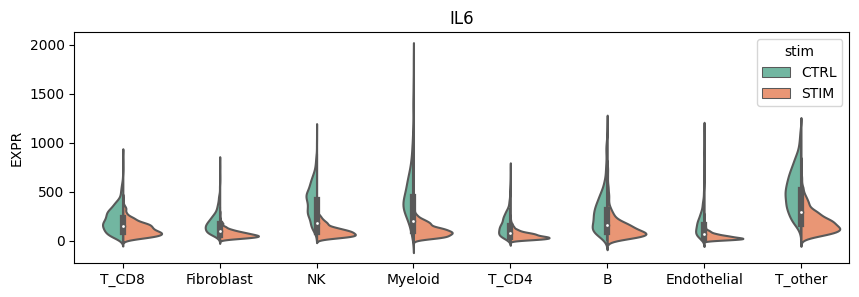

In [81]:

# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

d = {"IL6": adata_res1_df["IL6"].to_list(),
        "stim": adata_res1.obs["stim"].to_list(),
        "Y_max":  adata_res1.obs["Y_max"].to_list()}
curr_df = pd.DataFrame(data=d)

sns.violinplot(data=curr_df, 
        x="Y_max", y="IL6", hue="stim",
        ax= axs,
        split=True)

axs.set(ylabel="EXPR")


axs.set_title(f"IL6")
axs.set(xlabel=None)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2401565357.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2401565357.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


67
58
56
51
49
71
59
54
Fibroblast: 0.468691
Myeloid: 0.00063
T_other: 0.0
Endothelial: 0.0
T_CD4: 0.0
B: 0.0
NK: 0.0
T_CD8: 0.0


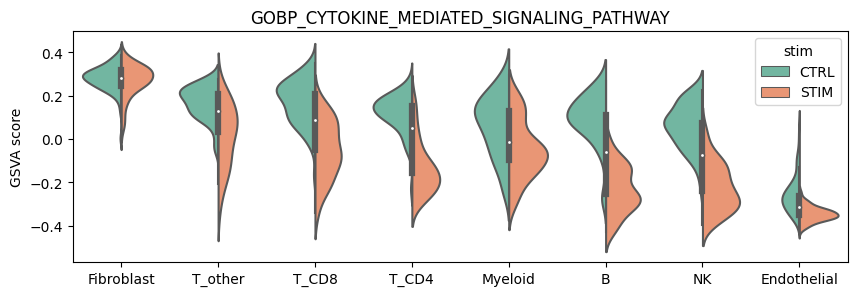

In [59]:


## replot to make nicer figure for the paper
curr_pathway = "GOBP_INFLAMMATORY_RESPONSE"
curr_pathway = "GOBP_INTERLEUKIN_6_PRODUCTION"
curr_pathway = "GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY"
# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

gsva_adata_res1 = gsva_adata_res1.astype({curr_pathway: float})


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

sns.violinplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list(),
        split=True)

axs.set(ylabel="GSVA score")


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.show()

Fibroblast_test = test_gsva_wilcox(gsva_adata_res1, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res1, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res1, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res1, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res1, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res1, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res1, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res1, "T_CD8", curr_pathway)

print(f"Fibroblast: {round(Fibroblast_test[1], 6)}")
print(f"Myeloid: {round(Myeloid_test[1], 6)}")
print(f"T_other: {round(T_other_test[1], 6)}")
print(f"Endothelial: {round(Endothelial_test[1], 6)}")
print(f"T_CD4: {round(T_CD4_test[1], 6)}")
print(f"B: {round(B_test[1], 6)}")
print(f"NK: {round(NK_test[1], 6)}")
print(f"T_CD8: {round(T_CD8_test[1], 6)}")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2167705962.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/2167705962.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


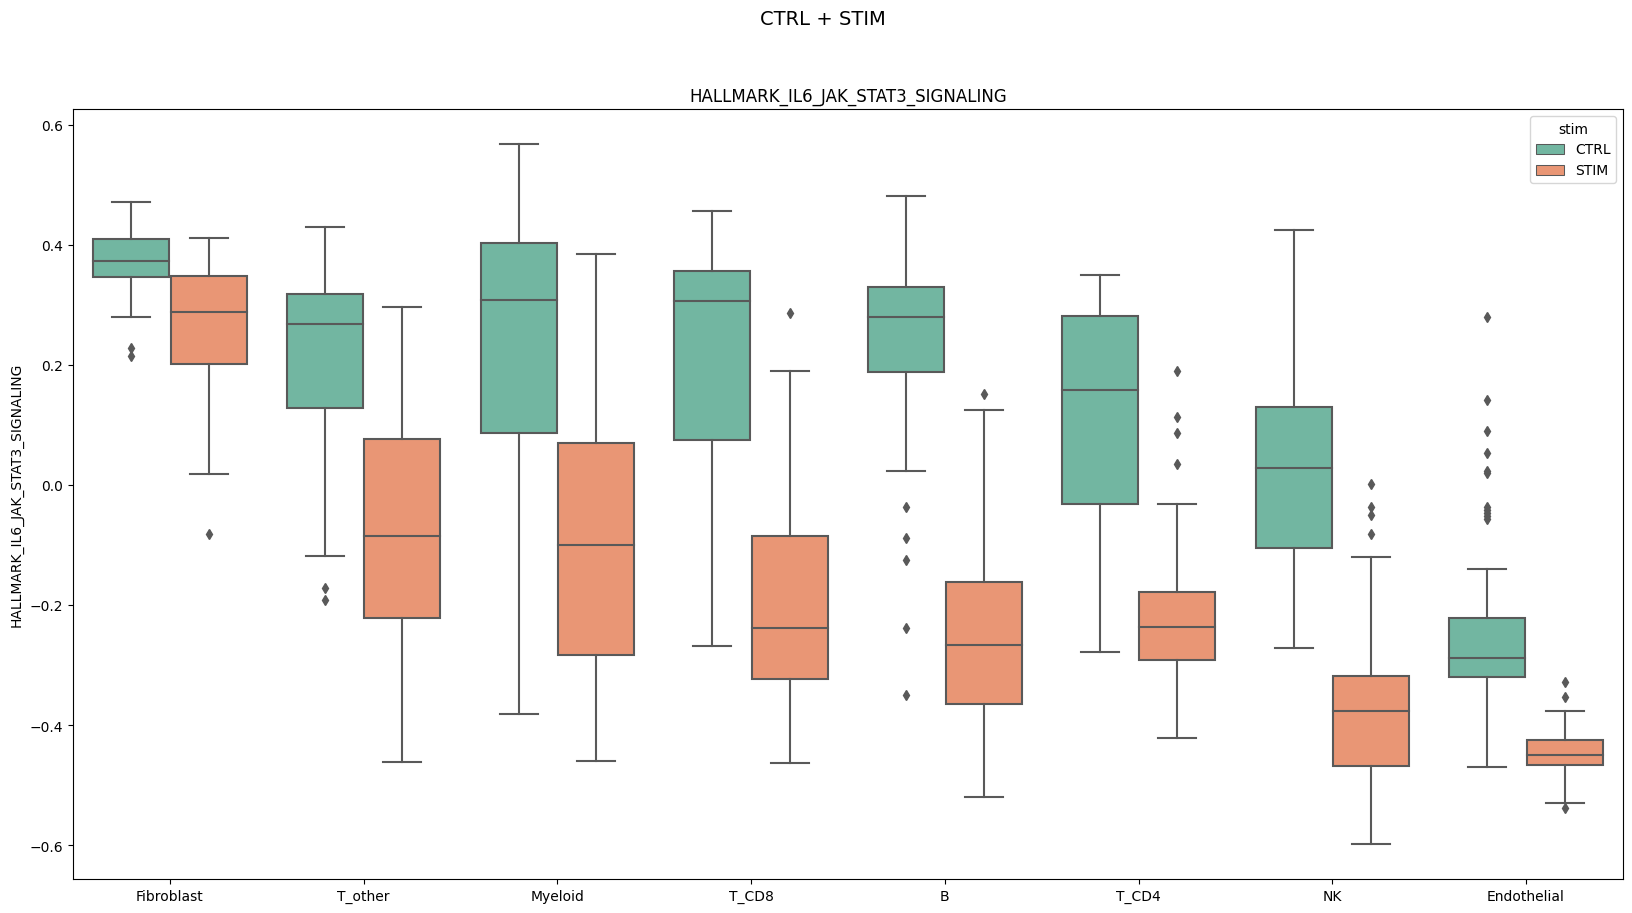

In [34]:
#### Res1 hallmark
gmt_path = gmt_path_hallmark

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res1 = get_cell_score_all(gmt_path, adata_res1, adata_res1_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()



In [35]:

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res1, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res1, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res1, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res1, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res1, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res1, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res1, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res1, "T_CD8", curr_pathway)

print(f"Fibroblast: {round(Fibroblast_test[1], 6)}")
print(f"Myeloid: {round(Myeloid_test[1], 6)}")
print(f"T_other: {round(T_other_test[1], 6)}")
print(f"Endothelial: {round(Endothelial_test[1], 6)}")
print(f"T_CD4: {round(T_CD4_test[1], 6)}")
print(f"B: {round(B_test[1], 6)}")
print(f"NK: {round(NK_test[1], 6)}")
print(f"T_CD8: {round(T_CD8_test[1], 6)}")

59
64
62
54
55
65
40
60
Fibroblast: 0.0
Myeloid: 0.0
T_other: 0.0
Endothelial: 0.0
T_CD4: 0.0
B: 0.0
NK: 0.0
T_CD8: 0.0


In [36]:
# test significance
curr_pathway = "HALLMARK_INFLAMMATORY_RESPONSE"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res1, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res1, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res1, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res1, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res1, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res1, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res1, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res1, "T_CD8", curr_pathway)

print(f"Fibroblast: {round(Fibroblast_test[1], 6)}")
print(f"Myeloid: {round(Myeloid_test[1], 6)}")
print(f"T_other: {round(T_other_test[1], 6)}")
print(f"Endothelial: {round(Endothelial_test[1], 6)}")
print(f"T_CD4: {round(T_CD4_test[1], 6)}")
print(f"B: {round(B_test[1], 6)}")
print(f"NK: {round(NK_test[1], 6)}")
print(f"T_CD8: {round(T_CD8_test[1], 6)}")

59
64
62
54
55
65
40
60
Fibroblast: 0.0
Myeloid: 0.872487
T_other: 0.0
Endothelial: 0.0
T_CD4: 0.0
B: 0.0
NK: 0.0
T_CD8: 0.0


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3928291801.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3928291801.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


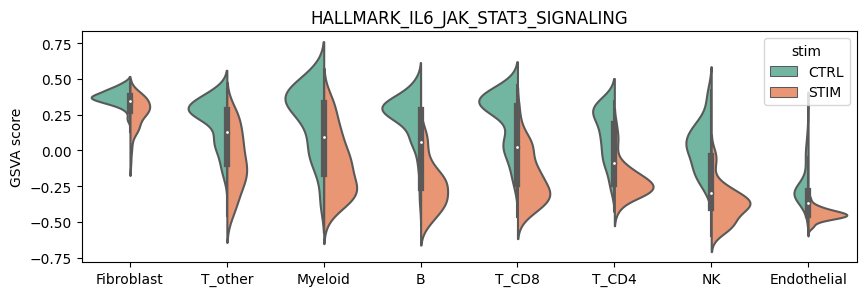

In [37]:
## replot to make nicer figure for the paper
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"


# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

gsva_adata_res1 = gsva_adata_res1.astype({curr_pathway: float})


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

sns.violinplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list(),
        split=True)

axs.set(ylabel="GSVA score")


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3558854975.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_82172/3558854975.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


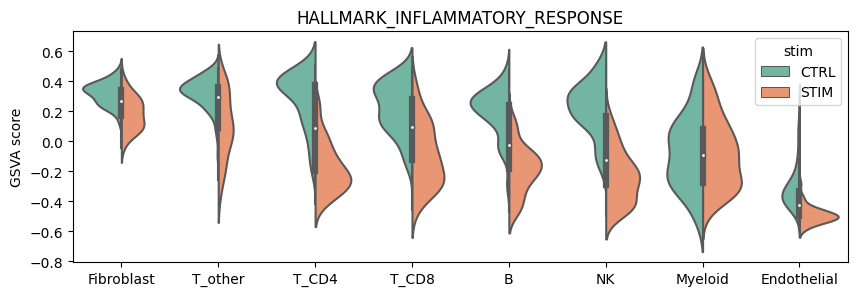

In [38]:
## also include the inflammatory response

curr_pathway = "HALLMARK_INFLAMMATORY_RESPONSE"


# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

gsva_adata_res1 = gsva_adata_res1.astype({curr_pathway: float})


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

sns.violinplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list(),
        split=True)

axs.set(ylabel="GSVA score")

axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.show()

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2343582276.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2343582276.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


58
66
61
64
45
67
59
61
Fibroblast: WilcoxonResult(statistic=330.0, pvalue=4.729567663213636e-05)
Myeloid: WilcoxonResult(statistic=41.0, pvalue=1.0453749276813951e-11)
T_other: WilcoxonResult(statistic=238.0, pvalue=3.7384781281439437e-07)
Endothelial: WilcoxonResult(statistic=88.0, pvalue=1.9338465896435903e-10)
T_CD4: WilcoxonResult(statistic=373.0, pvalue=0.1028795125620666)
B: WilcoxonResult(statistic=6.0, pvalue=1.4683150714313257e-12)
NK: WilcoxonResult(statistic=325.0, pvalue=2.3696811363134425e-05)
T_CD8: WilcoxonResult(statistic=301.0, pvalue=3.6690581230844017e-06)


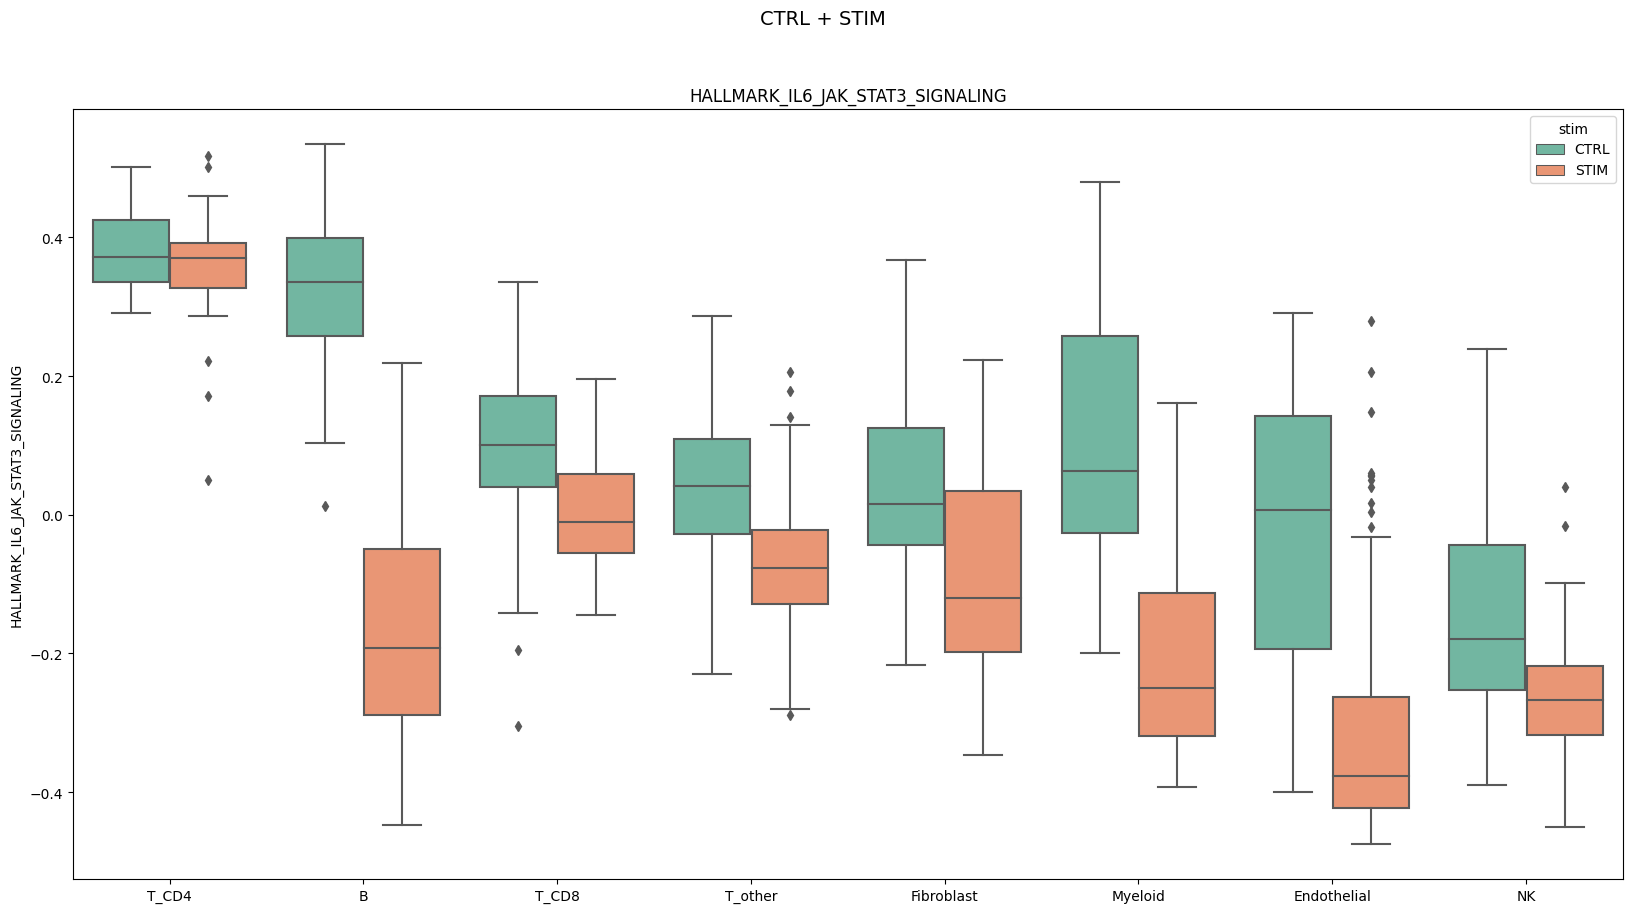

In [ ]:
#### Res2

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res2 = get_cell_score_all(gmt_path, adata_res2, adata_res2_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res2.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res2, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res2, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res2, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res2, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res2, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res2, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res2, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res2, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res2, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/411506120.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/411506120.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


59
56
54
61
55
74
62
55
Fibroblast: WilcoxonResult(statistic=782.0, pvalue=0.4368983210377153)
Myeloid: WilcoxonResult(statistic=45.0, pvalue=8.134295412622499e-10)
T_other: WilcoxonResult(statistic=659.0, pvalue=0.4721697541020634)
Endothelial: WilcoxonResult(statistic=43.0, pvalue=9.024197976469389e-11)
T_CD4: WilcoxonResult(statistic=555.0, pvalue=0.07164176726272269)
B: WilcoxonResult(statistic=220.0, pvalue=3.182892436035783e-10)
NK: WilcoxonResult(statistic=64.0, pvalue=1.578337715875675e-10)
T_CD8: WilcoxonResult(statistic=724.0, pvalue=0.6999312910961195)


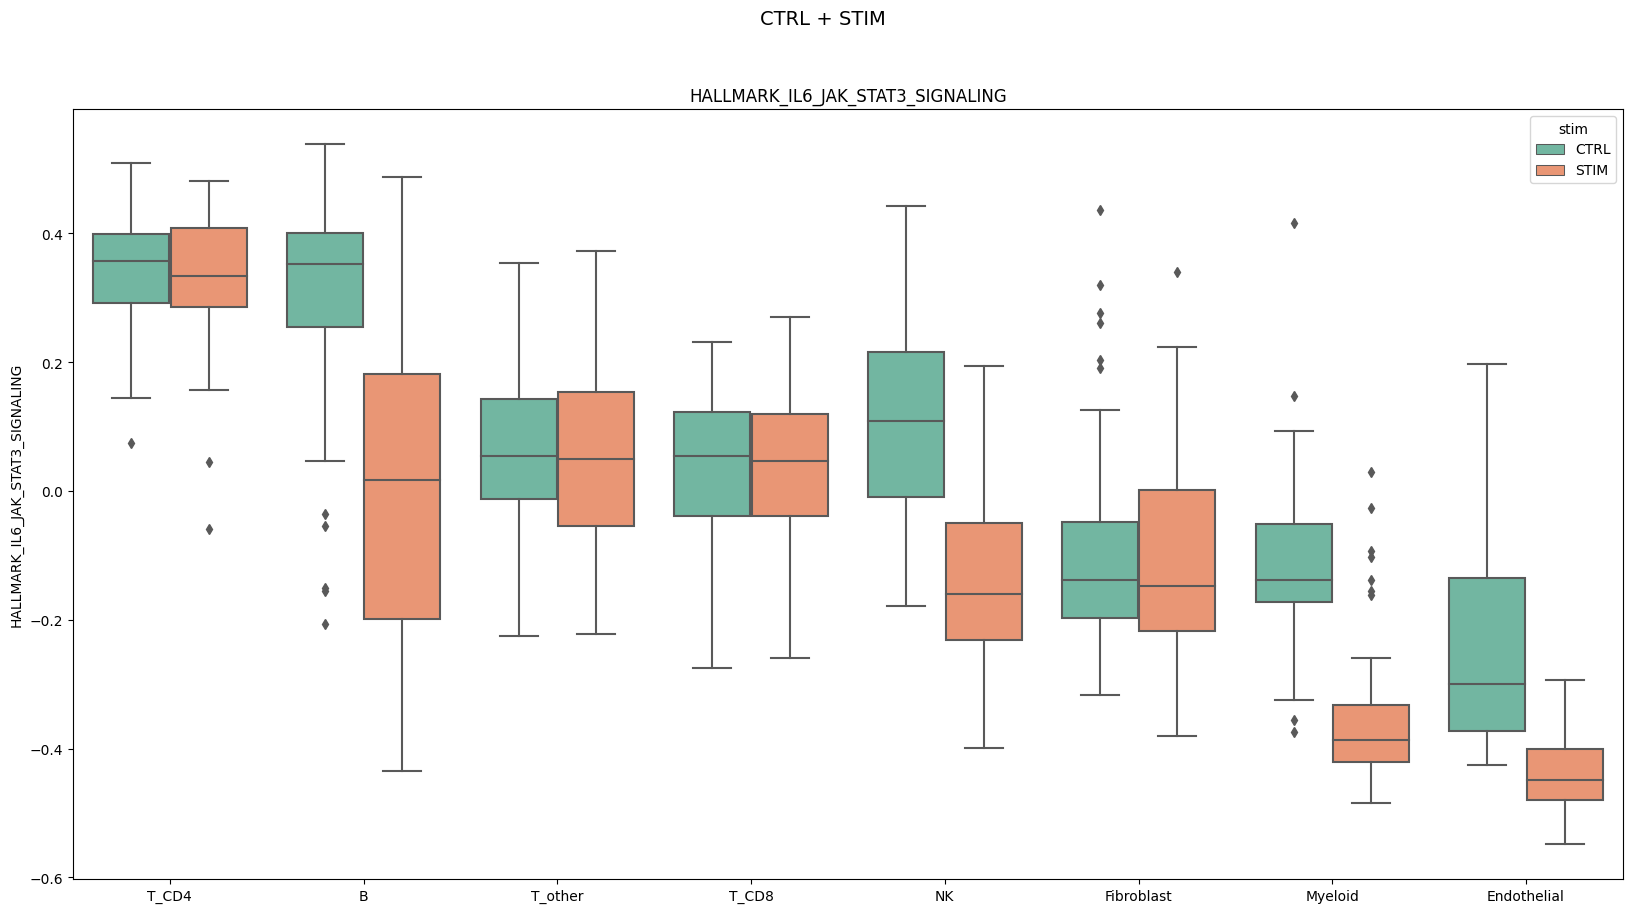

In [ ]:
#### Res3

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res3 = get_cell_score_all(gmt_path, adata_res3, adata_res3_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res3.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res3, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res3, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res3, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res3, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res3, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res3, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res3, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res3, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res3, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


### BayesPrism

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2636982990.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


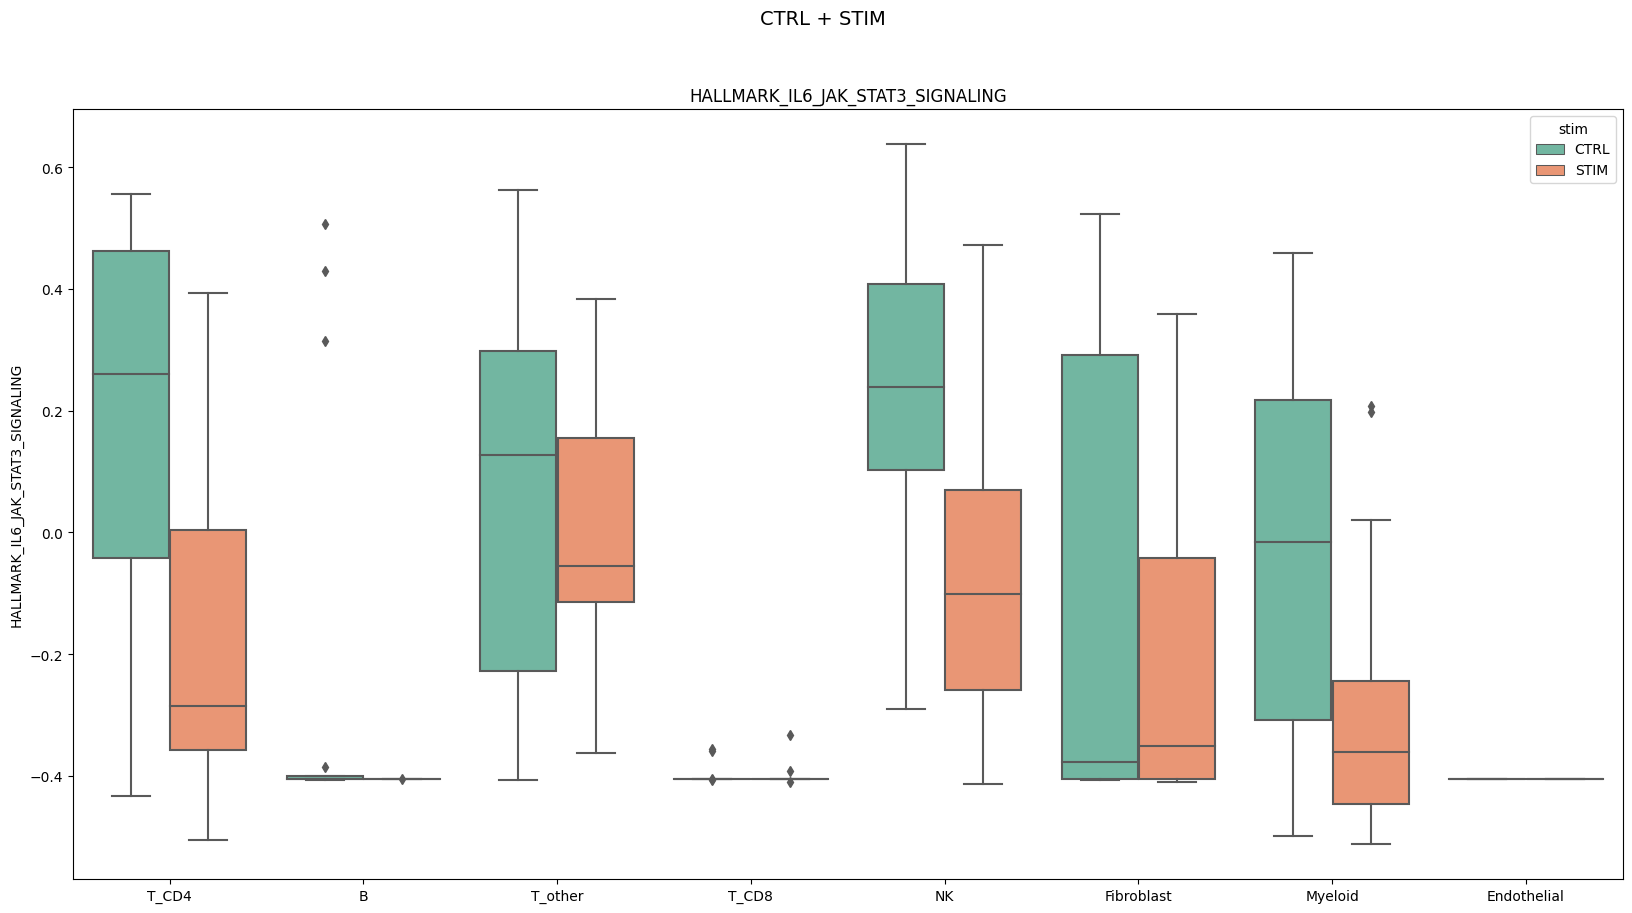

In [ ]:
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_bp_adata = get_cell_score_all(gmt_path, bp_adata, bp_adata_df, kcdf="Poisson")


fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_bp_adata, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()


In [ ]:
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_bp_adata, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_bp_adata, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_bp_adata, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_bp_adata, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_bp_adata, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_bp_adata, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_bp_adata, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_bp_adata, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


16
16
16
16


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.